# Sommaire

* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) Nettoyage du jeu de données](#ii)
* [III) Requêtes d'Antoine](#iii)
    * [1) Chiffre d'affaire (évolution + moyenne mobile)](#iii1)
    * [2) Octobre 2021](#iii2)
    * [3) Profils clients + courbe de Lorenz](#iii3)
    * [4) Tops et flops](#iii4)
* [IV) Requêtes de Julie](#iv)
    * [1) Genre/catégorie](#iv1)
    * [2) Requêtes liées à l'âge](#iv2)
        * [i) Un peu de visualisation pour commencer](#iv2i)
        * [ii) Âge/montant](#iv2ii)
        * [iii) Âge/fréquence](#iv2iii)
        * [iv) Âge/taille du panier](#iv2iv)
        * [v) Âge/catégorie](#iv2v)
        * [vi) Quelle coïncidence !](#iv2vi)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>

Dans ce notebook nous allons faire le point sur les performance de la boutique en ligne de Lapage depuis son ouverture il y a 2 ans.

Pour ce faire, nous allons analyser le chiffre d'affaire, la performance ou le manque de performance de certaines références, ainsi que des catégories de produits. Mais également le comportement des clients en fonction de leur genre ou de leur âge.

# I) Importation des données <a class="anchor" id="i"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
import math

In [2]:
customers = pd.read_csv('customers.csv')
customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [3]:
products = pd.read_csv('products.csv')
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


In [4]:
transactions = pd.read_csv('transactions.csv')
transactions

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


# II) Nettoyage du jeu de données <a class="anchor" id="ii"></a>

In [5]:
#Recherche des erreurs de type
customers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [6]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [7]:
transactions.dtypes
#Impossible de changer le format de date pour l'instant (message d'erreur), on continue notre nettoyage et on réessaie plus tard

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [8]:
#Recherche de valeurs manquantes
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [9]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [10]:
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [11]:
#Recherche de doublons
customers.loc[customers.duplicated(subset='client_id', keep=False)]

,client_id,sex,birth


In [12]:
products.loc[products.duplicated(subset='id_prod', keep=False)]

,id_prod,price,categ


In [13]:
transactions.loc[transactions.duplicated(subset=['id_prod', 'client_id', 'session_id', 'date'], keep=False)]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
19312,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0
...,...,...,...,...
653098,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [14]:
#Qu'est-ce que c'est que ce produit T_0 ?
products.loc[products['id_prod'] == 'T_0']

,id_prod,price,categ
731,T_0,-1.0,0


In [15]:
transactions.loc[transactions['id_prod'] == 'T_0']

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [16]:
#Petite enquête sur ct_0 et ct_1
customers.loc[(customers['client_id'] == 'ct_0') | (customers['client_id'] == 'ct_1')]

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


In [17]:
transactions.loc[(transactions['client_id'] == 'ct_0') | (transactions['client_id'] == 'ct_1')]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [18]:
#Petite enquête sur la session s_0
transactions.loc[transactions['session_id'] == 's_0']

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


Après concertation avec mon mentor, j'ai la confirmation que le produit T_0, la session s_0 et les clients ct_0 et ct_1 sont des tests que je peux les supprimer du jeu de données. Ce qui règlera par la même occasion la question des doublons.

In [19]:
customers_drop = customers.drop(index=[2735, 8494]).reset_index(drop=True)
customers_drop

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [20]:
products_drop = products.drop(index=731).reset_index(drop=True)
products_drop

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [21]:
transactions_drop = transactions.drop(transactions.loc[transactions['session_id'] == 's_0'].index, inplace=False).reset_index(drop=True)
transactions_drop

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


In [22]:
#Essayons une nouvelle fois de changer le format date, maintenant que les tests sont supprimés
transactions_drop['date'] = pd.to_datetime(transactions_drop['date'])
transactions_drop.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

In [23]:
#Recherche d'outliers et valeurs aberrantes
customers_drop.describe()

,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [24]:
customers_drop.sort_values('birth').head(10)
#A priori, plusieurs personnes de plus de 90 ans utilisent la boutique, sans doute pas des valeurs aberrantes

,client_id,sex,birth
4568,c_577,m,1929
2491,c_8362,f,1929
418,c_5302,m,1929
1086,c_3218,f,1930
5137,c_7232,f,1930
7549,c_353,m,1930
3993,c_4679,f,1930
3111,c_4334,m,1931
4573,c_8350,f,1931
751,c_4812,m,1931


In [25]:
customers_drop['sex'].unique()
#Pas d'abberation non plus du côté du sexe des clients

array(['f', 'm'], dtype=object)

In [26]:
products_drop.describe()

,price,categ
count,3286.000000,3286.000000
mean,21.863597,0.370359
std,29.849786,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [27]:
products_drop.sort_values('price').head(10)
#Plusieurs articles à moins d'1€

,id_prod,price,categ
2271,0_528,0.62,0
2354,0_202,0.62,0
370,0_120,0.66,0
1210,0_1844,0.77,0
1529,0_1620,0.80,0
2301,0_1364,0.81,0
2424,0_612,0.88,0
2771,0_902,0.92,0
686,0_2138,0.93,0
847,0_180,0.97,0


In [28]:
products_drop.sort_values('price', ascending=False).head(10)
#Plusieurs articles à plus de 200€

,id_prod,price,categ
946,2_2,300.00,2
724,2_76,254.44,2
394,2_158,247.22,2
1435,2_167,236.99,2
2778,2_30,233.54,2
1959,2_125,231.99,2
2486,2_166,230.04,2
785,2_40,228.11,2
10,2_228,225.17,2
1895,2_4,222.97,2


# III) Requêtes d'Antoine <a class="anchor" id="iii"></a>
## 1) Chiffre d'affaire (évolution + moyenne mobile) <a class="anchor" id="iii1"></a>

In [29]:
#On créé des colonnes années, mois et jours à partir de la colonne date
transactions_drop['year'] = transactions_drop['date'].dt.to_period('Y')
transactions_drop['month'] = transactions_drop['date'].dt.to_period('M')
transactions_drop['day'] = transactions_drop['date'].dt.to_period('D')
transactions_drop

,id_prod,date,session_id,client_id,year,month,day
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,2022-06,2022-06-18
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11
...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16


In [30]:
#On joint les tables transactions et produits
merged = transactions_drop.merge(products_drop, how='left')
merged

,id_prod,date,session_id,client_id,year,month,day,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0.0
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1.0
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,2022-06,2022-06-18,7.99,0.0
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2.0
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0.0
...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0.0
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1.0
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0.0
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0.0


In [31]:
#On vérifie s'il manque des données après la jointure
merged.isnull().sum()

id_prod         0
date            0
session_id      0
client_id       0
year            0
month           0
day             0
price         221
categ         221
dtype: int64

In [32]:
missing_article = merged.loc[merged['price'].isnull(),:]
missing_article

,id_prod,date,session_id,client_id,year,month,day,price,categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,2022,2022-09,2022-09-23,NaN,NaN
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,2022,2022-07,2022-07-23,NaN,NaN
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,2022,2022-12,2022-12-03,NaN,NaN
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,2021,2021-08,2021-08-16,NaN,NaN
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,2022,2022-07,2022-07-16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,2021,2021-08,2021-08-25,NaN,NaN
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,2022,2022-03,2022-03-06,NaN,NaN
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,2022,2022-05,2022-05-16,NaN,NaN
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,2022,2022-02,2022-02-11,NaN,NaN


In [33]:
merged.loc[merged['categ'].isnull(),:]
#Même nombre de lignes renvoyées pour le prix et la catégorie

,id_prod,date,session_id,client_id,year,month,day,price,categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,2022,2022-09,2022-09-23,NaN,NaN
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,2022,2022-07,2022-07-23,NaN,NaN
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,2022,2022-12,2022-12-03,NaN,NaN
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,2021,2021-08,2021-08-16,NaN,NaN
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,2022,2022-07,2022-07-16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,2021,2021-08,2021-08-25,NaN,NaN
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,2022,2022-03,2022-03-06,NaN,NaN
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,2022,2022-05,2022-05-16,NaN,NaN
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,2022,2022-02,2022-02-11,NaN,NaN


In [34]:
missing_article['id_prod'].unique()
#Il s'agit d'un seul et même article

array(['0_2245'], dtype=object)

Le produit 0_2245 est absent de notre jeu de données, cependant en comparant avec les autres références, on comprend aisément qu'il appartient à la catégorie 0 (le premier chiffre de chaque référence correspond à sa catégorie).

Ne pouvant pas deviner avec exactitude le prix du produit, nous pouvons lui attribuer la valeur moyenne des produits de la catégorie 0. En effet, ce produit ayant été vendu plus de 200 fois, il me semble plus judicieux de lui attribuer une valeur  plutôt que de le supprimer.

In [35]:
products_drop.groupby('categ')['price'].mean().round(2)

categ
0     11.73
1     25.53
2    108.35
Name: price, dtype: float64

In [36]:
#On créé une copie au cas où
copy = merged.copy()
copy

,id_prod,date,session_id,client_id,year,month,day,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0.0
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1.0
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,2022-06,2022-06-18,7.99,0.0
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2.0
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0.0
...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0.0
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1.0
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0.0
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0.0


In [37]:
copy['price'].fillna(11.73, inplace = True)
copy['categ'].fillna(0, inplace = True)
copy.isnull().sum()
#Ca a marché, une dernière manipulation puis on s'attaque au chiffre d'affaire

id_prod       0
date          0
session_id    0
client_id     0
year          0
month         0
day           0
price         0
categ         0
dtype: int64

In [38]:
copy['categ'] = copy['categ'].astype(int)
copy

,id_prod,date,session_id,client_id,year,month,day,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,2022-06,2022-06-18,7.99,0
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0
...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0


In [39]:
#On joint désormais la table customers
data = copy.merge(customers_drop, how='left')
data

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0,f,1986
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1,m,1988
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,2022-06,2022-06-18,7.99,0,f,1968
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2,m,2000
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0,m,1980
...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0,f,1951
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1,f,1977
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0,f,1988
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0,m,1986


In [40]:
#On vérifie s'il manque des données après la jointure
data.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
year          0
month         0
day           0
price         0
categ         0
sex           0
birth         0
dtype: int64

In [41]:
#J'ajoute une colonne âge pour plus tard
data = data.assign(age = data['year'] - data['birth'])
#J'obtiens un âge sur 4 chiffres alors j'effectue cette manipulation pour les retirer
data['age'] = data['age'].astype(str)
data['age'] = data['age'].astype(int)
data

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0,f,1986,36
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1,m,1988,34
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,2022,2022-06,2022-06-18,7.99,0,f,1968,54
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2,m,2000,21
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0,m,1980,43
...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0,f,1951,71
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1,f,1977,45
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0,f,1988,34
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0,m,1986,35


In [42]:
#On s'attaque au CA pour de bon cette fois
ca_month = data.groupby('month')['price'].sum().reset_index()
ca_month.rename(columns={'price':'chiffre_affaire'}, inplace=True)
ca_month

,month,chiffre_affaire
0,2021-03,482546.18
1,2021-04,476273.52
2,2021-05,493037.31
3,2021-06,484170.67
4,2021-07,482882.32
5,2021-08,482390.36
6,2021-09,507381.44
7,2021-10,320880.85
8,2021-11,516285.03
9,2021-12,525999.39


In [43]:
#Avant de faire un graphique, on décompose en moyenne mobile
ca_month['moyenne_mobile'] = ca_month['chiffre_affaire'].rolling(window=3).mean().round(2)
ca_month

,month,chiffre_affaire,moyenne_mobile
0,2021-03,482546.18,NaN
1,2021-04,476273.52,NaN
2,2021-05,493037.31,483952.34
3,2021-06,484170.67,484493.83
4,2021-07,482882.32,486696.77
5,2021-08,482390.36,483147.78
6,2021-09,507381.44,490884.71
7,2021-10,320880.85,436884.22
8,2021-11,516285.03,448182.44
9,2021-12,525999.39,454388.42


<function matplotlib.pyplot.show(close=None, block=None)>

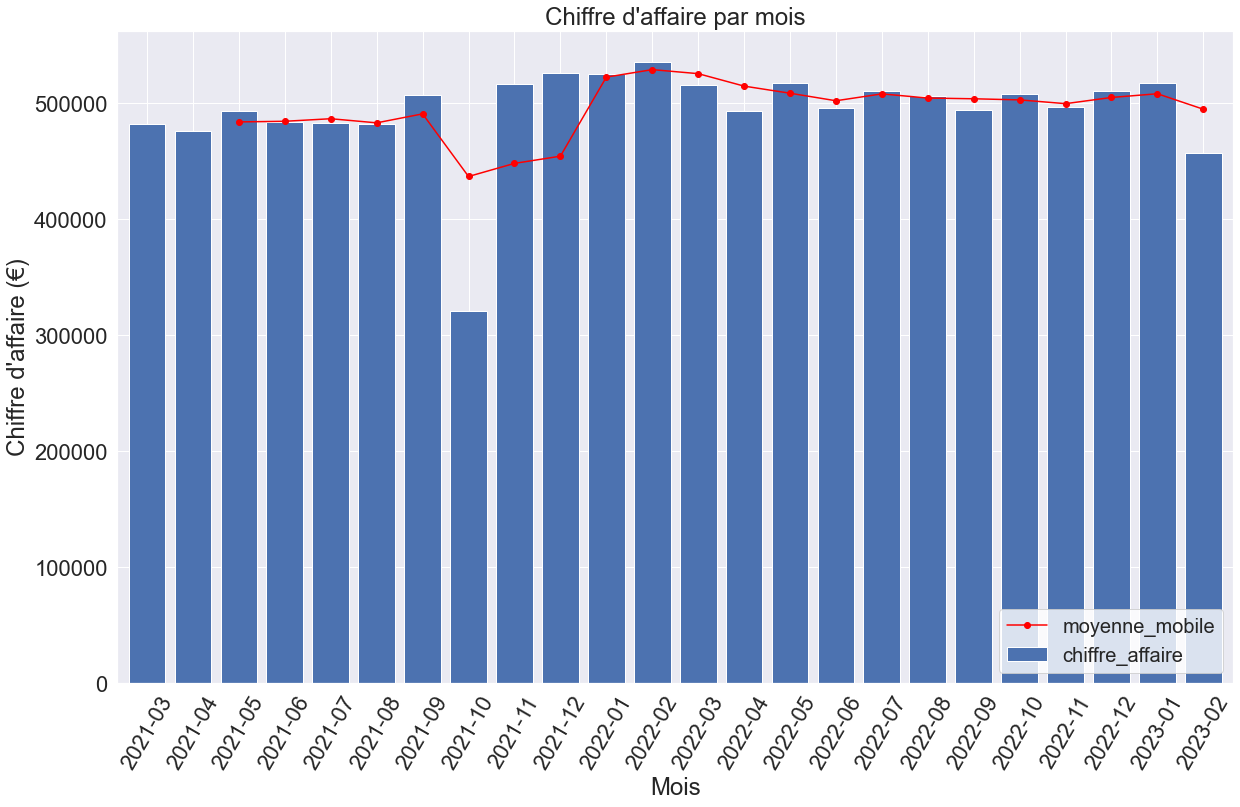

In [44]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,12))
ca_month['chiffre_affaire'].plot(x='month', kind='bar', width=0.8)
ca_month['moyenne_mobile'].plot(x='month', kind='line', color='red', marker='o')
ax.set_xticklabels(ca_month['month'])
plt.title("Chiffre d'affaire par mois")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Mois")
plt.xticks(rotation=60)
sns.set_theme(style='whitegrid', palette='dark')
plt.legend(loc='lower right', prop={'size': 20})

plt.show

In [45]:
print('\033[1m' "La moyenne mobile semble stagner depuis environ un an. Le mois d'octobre 2021 se démarque assez nettement des autres mois cependant, voyons si on peut l'expliquer." '\033[0m')

La moyenne mobile semble stagner depuis environ un an. Le mois d'octobre 2021 se démarque assez nettement des autres mois cependant, voyons si on peut l'expliquer.


## 2) Octobre 2021 <a class="anchor" id="iii2"></a>

In [46]:
#Commencons pas regarder du côté des catégories de produit
ca_categ = data.groupby('categ')['price'].sum().reset_index()
ca_categ

,categ,price
0,0,4422323.30
1,1,4653722.69
2,2,2780275.02


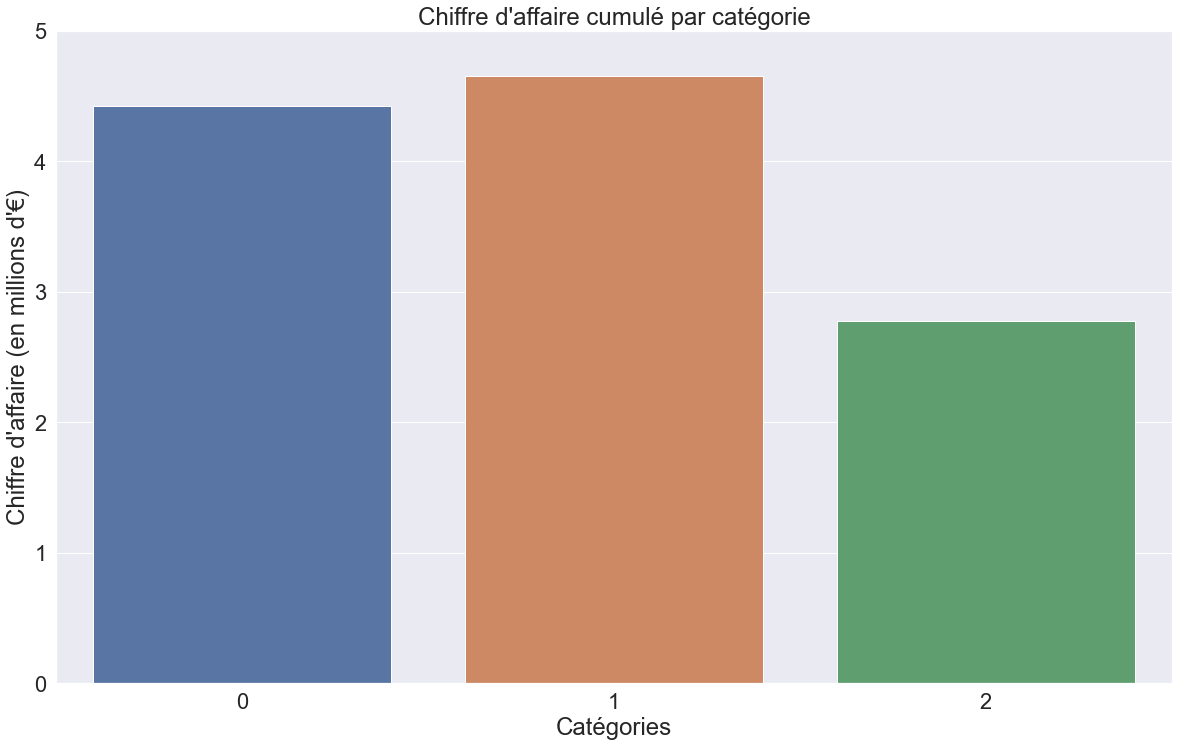

In [47]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g1 = sns.barplot(data=ca_categ, x='categ', y='price', ci=None, estimator=sum)
plt.title("Chiffre d'affaire cumulé par catégorie")
plt.ylabel("Chiffre d'affaire (en millions d'€)")
plt.xlabel("Catégories")
plt.ylim (0,5000000)
ylabels = ['{:,.0f}'.format(y) for y in g1.get_yticks()/1000000] #Pour avoir l'axe y en millions d'€
g1.set_yticks([0, 1000000, 2000000, 3000000, 4000000, 5000000])
g1.set_yticklabels(ylabels)
sns.set_theme(style='whitegrid', palette='dark')
plt.show()

In [48]:
#Les catégories 0 et 1 semblent mieux performer que la catégorie 2, mais cela n'explique pas le mois d'octobre 2021
#On va donc regarder l'évolution du chiffre d'affaire par mois et par catégorie
ca_categ_month = data.groupby(['categ', 'month'])['price'].sum().reset_index()
ca_categ_month.rename(columns={'price':'chiffre_affaire'}, inplace=True)
ca_categ_month

,categ,month,chiffre_affaire
0,0,2021-03,193734.74
1,0,2021-04,205386.68
2,0,2021-05,196280.56
3,0,2021-06,168025.26
4,0,2021-07,144797.71
...,...,...,...
67,2,2022-10,120878.94
68,2,2022-11,111642.60
69,2,2022-12,123803.09
70,2,2023-01,126153.08


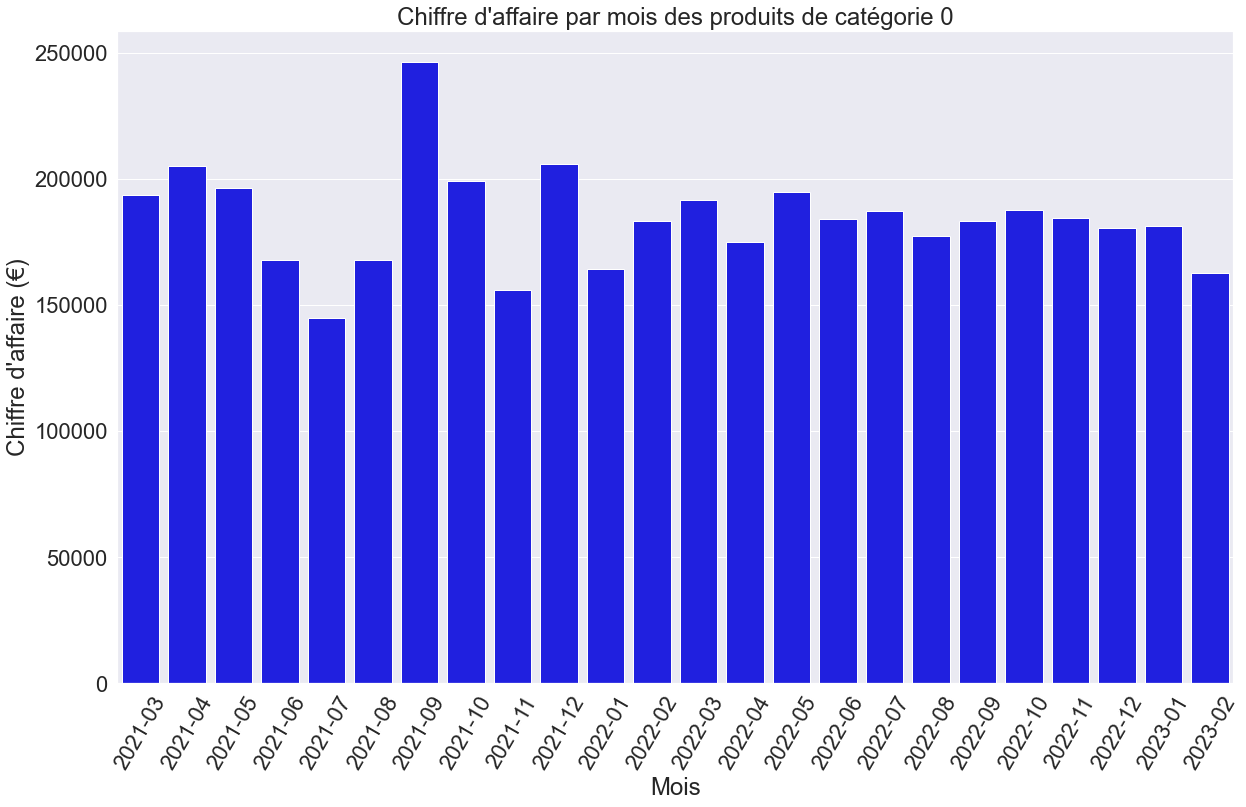

In [49]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g2 = sns.barplot(data=ca_categ_month.loc[ca_categ_month['categ'] == 0], x='month', y='chiffre_affaire', ci=None, estimator=sum, color='blue')
plt.title("Chiffre d'affaire par mois des produits de catégorie 0")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Mois") 
plt.xticks(rotation=60)
sns.set_theme(style='whitegrid', palette='dark')
plt.show()
#Rien de suspicieux en octobre 2021

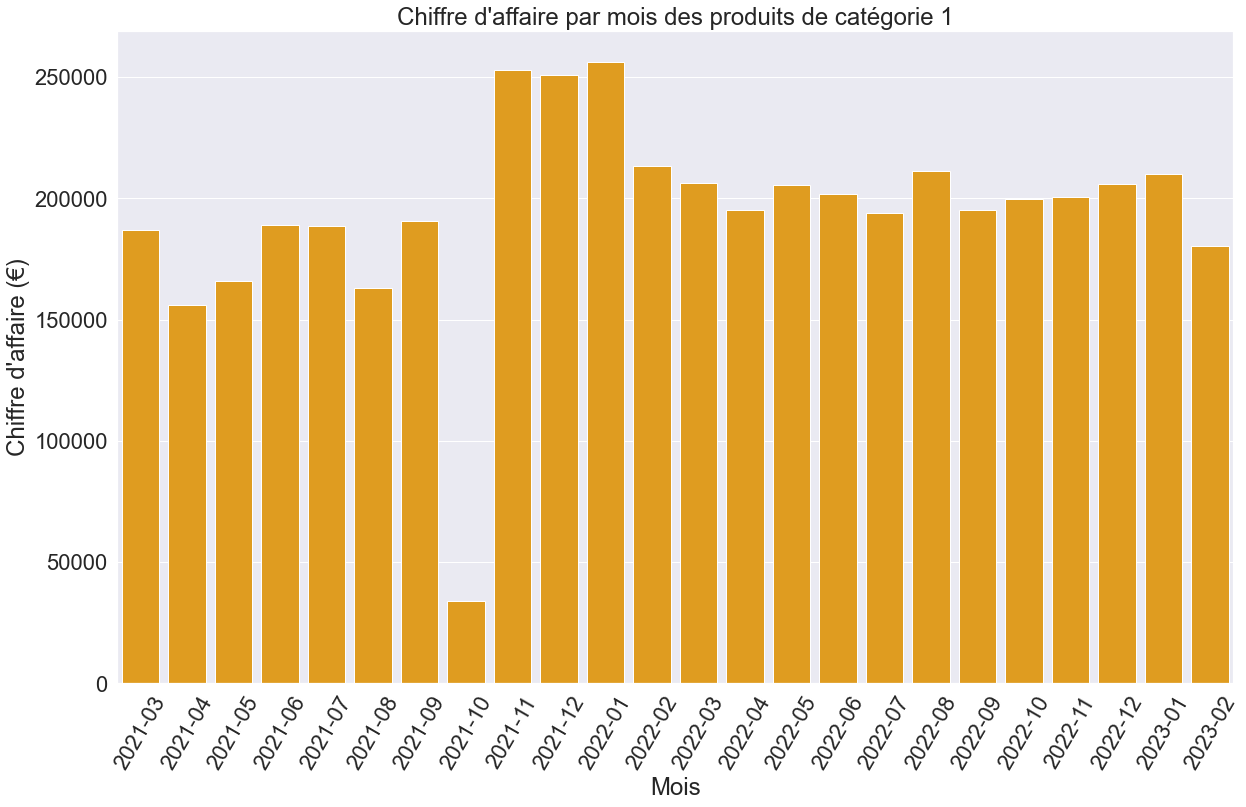

In [50]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g3 = sns.barplot(data=ca_categ_month.loc[ca_categ_month['categ'] == 1], x='month', y='chiffre_affaire', ci=None, estimator=sum, color='orange')
plt.title("Chiffre d'affaire par mois des produits de catégorie 1")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Mois") 
plt.xticks(rotation=60)
sns.set_theme(style='whitegrid', palette='dark')
plt.show()
#Ecroulement total en octobre 2021 !

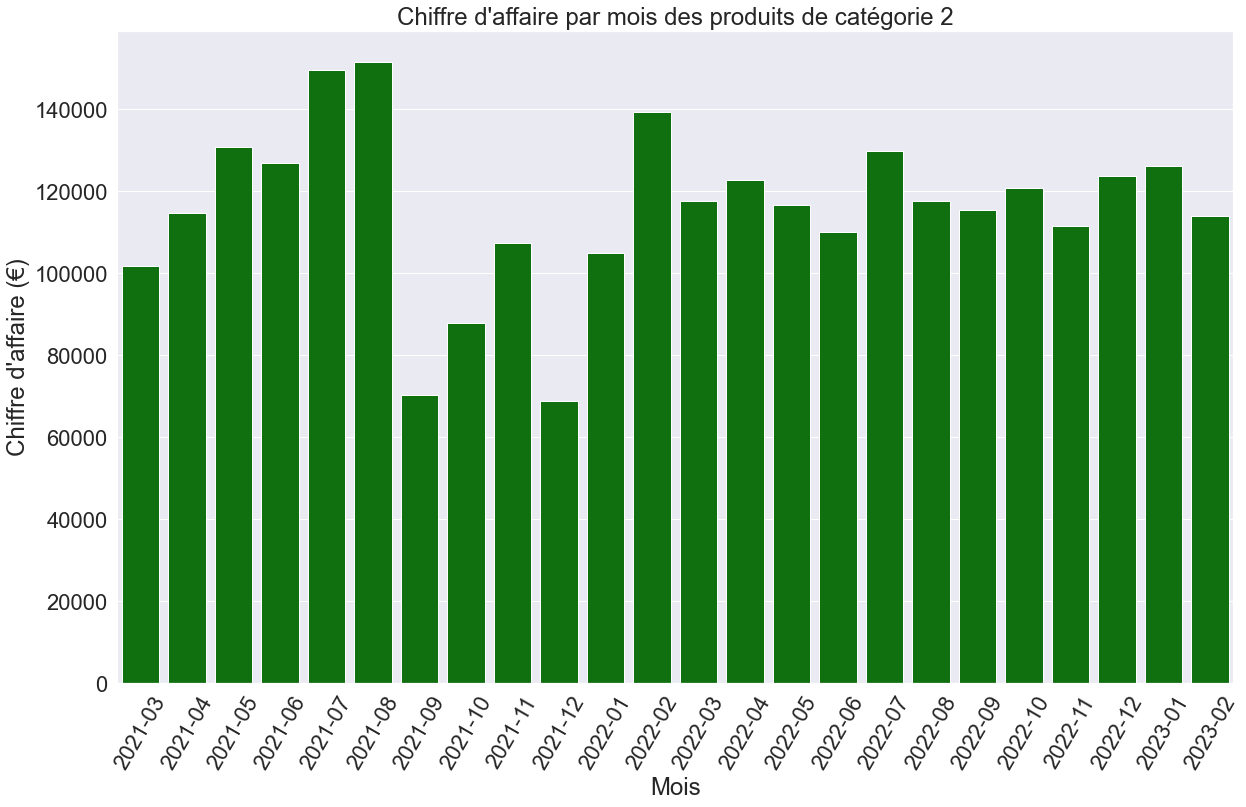

In [51]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g4 = sns.barplot(data=ca_categ_month.loc[ca_categ_month['categ'] == 2], x='month', y='chiffre_affaire', ci=None, estimator=sum, color='green')
plt.title("Chiffre d'affaire par mois des produits de catégorie 2")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Mois") 
plt.xticks(rotation=60)
sns.set_theme(style='whitegrid', palette='dark')
plt.show()
#Performances médiocres en octobre 2021, mais la catégorie 2 a connu pire

In [52]:
pivot = ca_categ_month.pivot_table(index='month', columns='categ', values='chiffre_affaire', aggfunc='sum')
pivot

categ,0,1,2
month,,,
2021-03,193734.74,186974.17,101837.27
2021-04,205386.68,156138.35,114748.49
2021-05,196280.56,165893.40,130863.35
2021-06,168025.26,189162.04,126983.37
2021-07,144797.71,188523.27,149561.34
2021-08,167843.19,162991.38,151555.79
2021-09,246494.67,190613.78,70272.99
2021-10,199332.94,33762.32,87785.59
2021-11,156026.86,252910.39,107347.78


<function matplotlib.pyplot.show(close=None, block=None)>

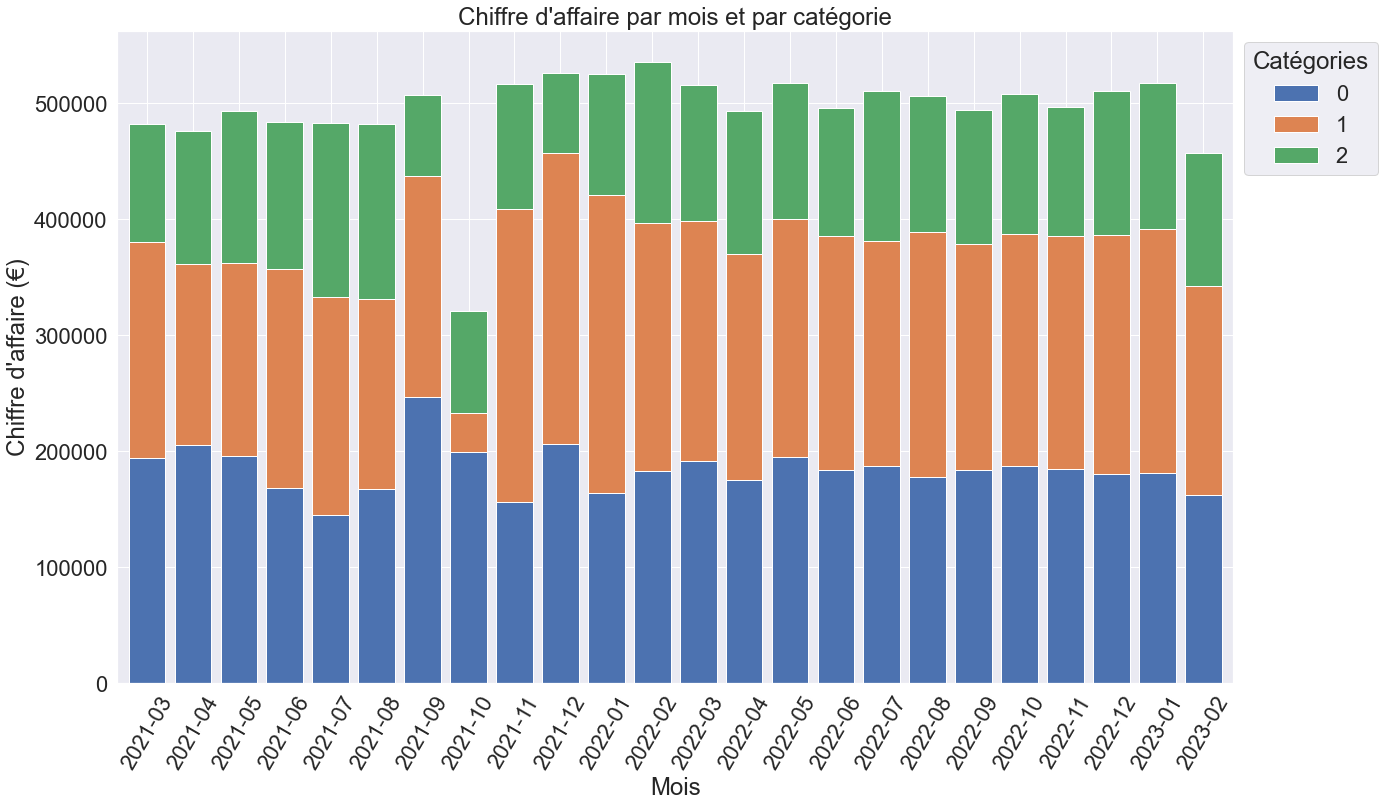

In [53]:
#Pour une vue globale
sns.set(font_scale=2)
g5 = pivot.plot(kind='bar', stacked=True, figsize=(20,12), width=0.8)
plt.title("Chiffre d'affaire par mois et par catégorie")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Mois")
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=[1, 1], title='Catégories')
sns.set_theme(style='whitegrid', palette='dark')
plt.show

In [54]:
#Creusons plus loin en nous intéressant aux jours du mois d'octobre 2021
oct2021 = data.groupby(['categ', 'month', 'day'])['price'].sum().reset_index()
oct2021.rename(columns={'price':'chiffre_affaire'}, inplace=True)
oct2021 = oct2021.loc[oct2021['month'] == '2021-10']
oct2021

,categ,month,day,chiffre_affaire
214,0,2021-10,2021-10-01,6950.50
215,0,2021-10,2021-10-02,7141.01
216,0,2021-10,2021-10-03,6786.57
217,0,2021-10,2021-10-04,6557.06
218,0,2021-10,2021-10-05,6357.91
...,...,...,...,...
1674,2,2021-10,2021-10-27,3967.29
1675,2,2021-10,2021-10-28,2602.82
1676,2,2021-10,2021-10-29,3617.88
1677,2,2021-10,2021-10-30,2898.47


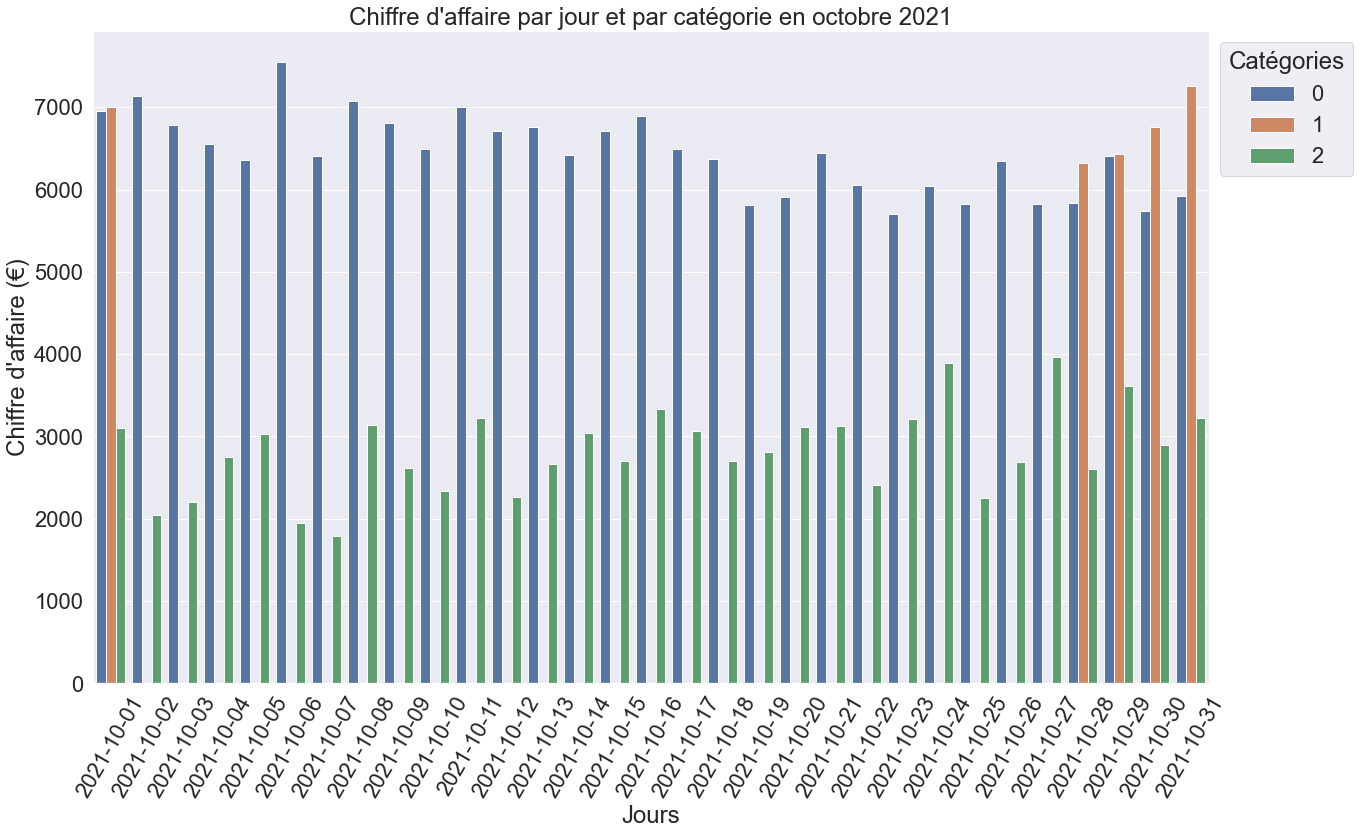

In [55]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g6 = sns.barplot(data=oct2021, x='day', y='chiffre_affaire', hue='categ', ci=None, estimator=sum)
plt.title("Chiffre d'affaire par jour et par catégorie en octobre 2021")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Jours") 
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=[1, 1], title='Catégories')
sns.set_theme(style='whitegrid', palette='dark')
plt.show()

In [56]:
print('\033[1m' "Il semblerait qu'aucune vente de produits de catégorie 1 n'ait été enregistrée entre le 2 et le 27 octobre 2021 inclus, ce qui explique la baisse de chiffre d'affaire." '\033[0m')

Il semblerait qu'aucune vente de produits de catégorie 1 n'ait été enregistrée entre le 2 et le 27 octobre 2021 inclus, ce qui explique la baisse de chiffre d'affaire.


## 3) Profils clients + courbe de Lorenz <a class="anchor" id="iii3"></a>

In [57]:
#Je souhaite voir s'il peut être intéressant de comparer le chiffre d'affaire entre clients f et m
data.groupby('sex')['sex'].count()
#Il y a sensiblement le même nombre de transactions (~0.7%)

sex
f    338402
m    340930
Name: sex, dtype: int64

In [58]:
data.groupby('sex')['price'].sum()

sex
f    5861055.54
m    5995265.47
Name: price, dtype: float64

In [59]:
prop_ = round(((5995265.47 - 5861055.54) * 100 / 5861055.54), 2)

print('\033[1m' "Les hommes dépensent " '\033[4m' + str(prop_) + "%" '\033[0m' '\033[1m' " de plus que les femmes" '\033[0m')

Les hommes dépensent 2.29% de plus que les femmes


In [60]:
#Même question en fonction de l'âge des clients
ca_age = data.groupby('age')['price'].sum().reset_index()
ca_age.rename(columns={'price':'chiffre_affaire'}, inplace=True)
ca_age.sort_values('chiffre_affaire', ascending=False).head(10)

,age,chiffre_affaire
25,42,468707.25
24,41,399461.84
1,18,384592.43
26,43,352114.70
6,23,347552.36
27,44,300461.99
5,22,299605.01
18,35,290012.23
17,34,289758.39
22,39,277071.13


<function matplotlib.pyplot.show(close=None, block=None)>

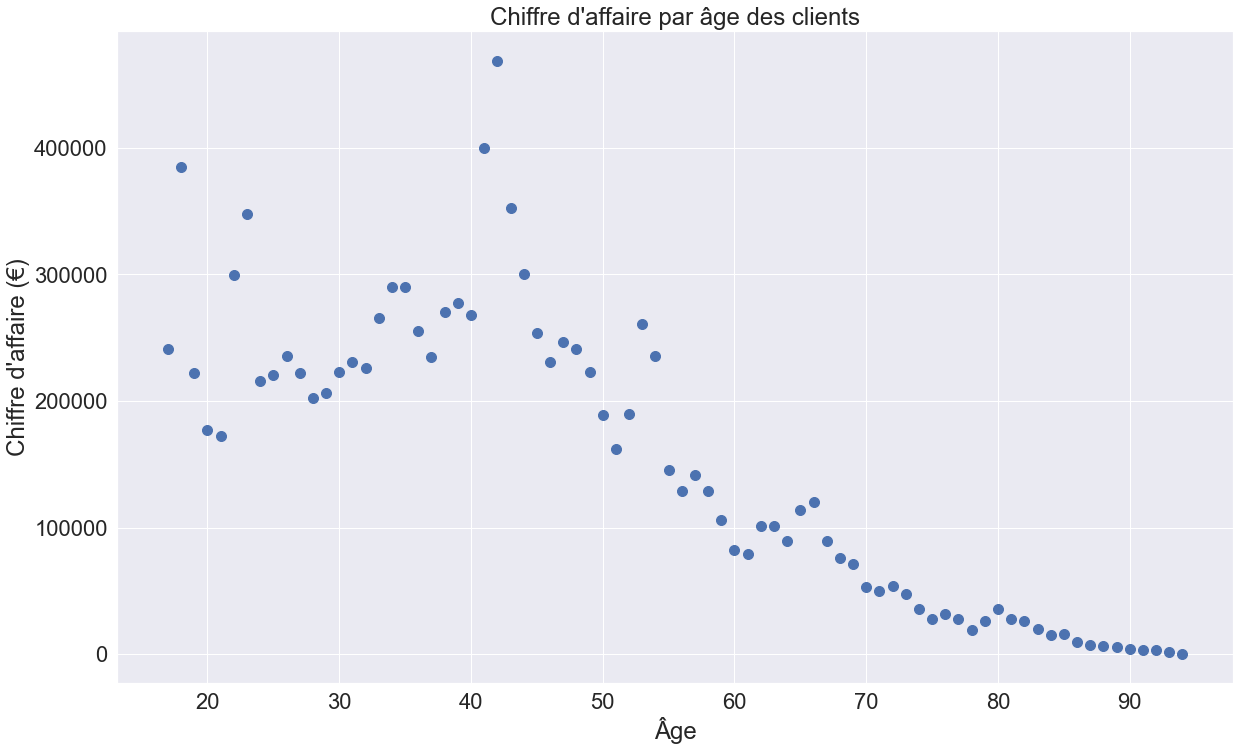

In [61]:
sns.set(font_scale=2)
g7 = ca_age.plot(kind="scatter", x='age', y='chiffre_affaire', color='b', figsize=(20,12), s=100)
plt.title("Chiffre d'affaire par âge des clients")
plt.ylabel("Chiffre d'affaire (€)")
plt.xlabel("Âge")
sns.set_theme(style='whitegrid', palette='dark')
plt.show

In [62]:
print('\033[1m' "Il semble que les clients de moins de 60 ans dépensent davantage. On remarque quelques outliers qui s'éloignent de la tendance générale." '\033[0m')

Il semble que les clients de moins de 60 ans dépensent davantage. On remarque quelques outliers qui s'éloignent de la tendance générale.


In [63]:
#On empiète un peu sur les requêtes de Julie, mais regardons du côté de la moyenne du chiffre d'affaire par âge
ca_age_moy = data.groupby('age')['price'].mean().reset_index()
ca_age_moy.rename(columns={'price':'moyenne_ca'}, inplace=True)
ca_age_moy.sort_values('moyenne_ca', ascending=False).head(10)

,age,moyenne_ca
6,23,45.960376
5,22,44.215615
7,24,41.313776
9,26,41.257141
2,19,41.026406
8,25,40.856270
0,17,40.651361
10,27,40.523773
11,28,40.134970
4,21,39.968295


<function matplotlib.pyplot.show(close=None, block=None)>

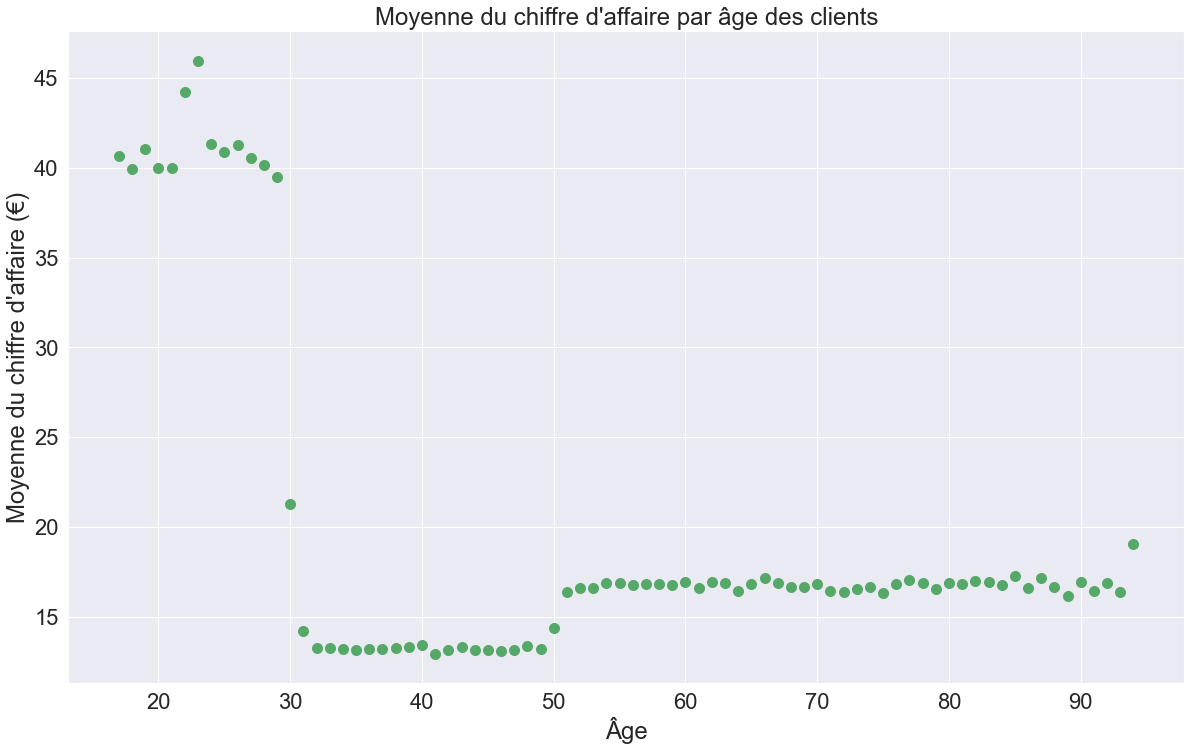

In [64]:
sns.set(font_scale=2)
g8 = ca_age_moy.plot(kind="scatter", x='age', y='moyenne_ca', color='g', figsize=(20,12), s=100)
plt.title("Moyenne du chiffre d'affaire par âge des clients")
plt.ylabel("Moyenne du chiffre d'affaire (€)")
plt.xlabel("Âge")
sns.set_theme(style='whitegrid', palette='dark')
plt.show

In [65]:
print('\033[1m' "La moyenne donne des résultats complètement différents. Le nombre d'individus plus ou moins élevés influe sur le chiffre d'affaire par âge. En regardant la moyenne, on s'apperçoit que les moins de 30 ans semblent dépenser davantage que les plus de 50 ans, qui eux-mêmes dépensent davantage que les 30/50 ans." '\033[0m')

La moyenne donne des résultats complètement différents. Le nombre d'individus plus ou moins élevés influe sur le chiffre d'affaire par âge. En regardant la moyenne, on s'apperçoit que les moins de 30 ans semblent dépenser davantage que les plus de 50 ans, qui eux-mêmes dépensent davantage que les 30/50 ans.


In [66]:
#La preuve en image, les clients les plus nombreux ont entre 30 et 50 ans
data.groupby('age')['age'].count().sort_values(ascending=False).head(20)

age
42    35592
41    30842
43    26478
44    22849
35    22056
34    21937
39    20816
38    20374
33    20057
40    19978
36    19345
45    19303
47    18702
48    18010
37    17743
46    17621
32    17052
49    16837
31    16234
53    15697
Name: age, dtype: int64

In [67]:
#On s'attaque à la courbe de Lorenz
ca_client = data.groupby('client_id')['price'].sum().reset_index()
ca_client.rename(columns={'price':'depenses'}, inplace=True)
ca_client.sort_values('depenses', ascending=False).head(10)
#On note pour plus tard que 4 clients ont des dépenses exhorbitantes

,client_id,depenses
677,c_1609,324033.35
4388,c_4958,289760.34
6337,c_6714,153669.30
2724,c_3454,113673.12
2513,c_3263,5276.87
634,c_1570,5271.62
2108,c_2899,5214.05
1268,c_2140,5208.82
7006,c_7319,5155.77
7791,c_8026,5094.31


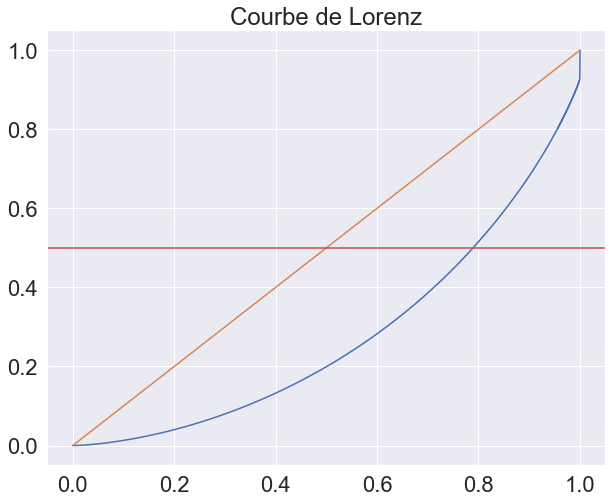

In [68]:
n = len(ca_client)

lorenz = np.cumsum(np.sort(ca_client['depenses'])) / ca_client['depenses'].sum()
lorenz = np.append([0],lorenz)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
plt.title('Courbe de Lorenz')
xaxis = np.linspace(0-1/n,1+1/n,len(lorenz))
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1]) #Tracer la 1ère bissectrice
plt.axhline(y=0.5, color='r', linestyle='-') #Tracer une ligne horizontale à l'ordonnée 0.5

plt.show()

In [69]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n #Surface sous la courbe de Lorenz
S = 0.5 - AUC #Surface entre la courbe de Lorenz et la première bissectrice
gini = 2*S
gini

0.44639658571467455

L'indice de Gini de 0.45 suggère qu'il y a concentration assez importante, mais pour utiliser un langage plus simple à comprendre : Environ 20% des clients ont dépensé 50% du chiffre d'affaire sur les 2 dernières années.

Je ne rentre pas plus dans le détail sur les profils des clients, on y reviendra plus tard avec les requêtes de Julie.
## 4) Tops et flops <a class="anchor" id="iii4"></a>

In [70]:
#Je tente une jointure externe pour voir si certains produits n'ont jamais été vendus
flops = data.merge(products_drop, how='outer')
flops

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0,f,1986.0,36.0
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,2021,2021-09,2021-09-26,4.18,0,m,1985.0,36.0
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,2021,2021-05,2021-05-06,4.18,0,f,1974.0,47.0
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,2022,2022-03,2022-03-16,4.18,0,f,1962.0,60.0
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,2022,2022-11,2022-11-12,4.18,0,f,1976.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...
679348,0_1624,NaT,NaN,NaN,NaT,NaT,NaT,24.50,0,NaN,NaN,NaN
679349,2_86,NaT,NaN,NaN,NaT,NaT,NaT,132.36,2,NaN,NaN,NaN
679350,0_299,NaT,NaN,NaN,NaT,NaT,NaT,22.99,0,NaN,NaN,NaN
679351,0_510,NaT,NaN,NaN,NaT,NaT,NaT,23.66,0,NaN,NaN,NaN


In [71]:
flops.isnull().sum()

id_prod        0
date          21
session_id    21
client_id     21
year          21
month         21
day           21
price          0
categ          0
sex           21
birth         21
age           21
dtype: int64

In [72]:
#On voit que 21 produits n'ont jamais été vendu en ligne sur ces 2 années
never_sold = flops.loc[flops['client_id'].isnull(),:]
never_sold

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age
679332,0_1016,NaT,NaN,NaN,NaT,NaT,NaT,35.06,0,NaN,NaN,NaN
679333,0_1780,NaT,NaN,NaN,NaT,NaT,NaT,1.67,0,NaN,NaN,NaN
679334,0_1062,NaT,NaN,NaN,NaT,NaT,NaT,20.08,0,NaN,NaN,NaN
679335,0_1119,NaT,NaN,NaN,NaT,NaT,NaT,2.99,0,NaN,NaN,NaN
679336,0_1014,NaT,NaN,NaN,NaT,NaT,NaT,1.15,0,NaN,NaN,NaN
679337,1_0,NaT,NaN,NaN,NaT,NaT,NaT,31.82,1,NaN,NaN,NaN
679338,0_1318,NaT,NaN,NaN,NaT,NaT,NaT,20.92,0,NaN,NaN,NaN
679339,0_1800,NaT,NaN,NaN,NaT,NaT,NaT,22.05,0,NaN,NaN,NaN
679340,0_1645,NaT,NaN,NaN,NaT,NaT,NaT,2.99,0,NaN,NaN,NaN
679341,0_322,NaT,NaN,NaN,NaT,NaT,NaT,2.99,0,NaN,NaN,NaN


In [73]:
#Cependant je ne peux pas savoir si ce sont des flops ou des produits qui sont simplement absents de la boutique en ligne
#Du coup je considère que les flops sont les produits les moins vendus, mais ayant été vendus au moins une fois
#Je décide de travailler par catégorie
flops_count = data.groupby(['id_prod', 'categ'])['id_prod'].count()
flops_count = flops_count.to_frame('decompte').reset_index()
flops0 = flops_count.loc[flops_count['categ'] == 0].sort_values('decompte').head(20)
flops0

,id_prod,categ,decompte
1327,0_2201,0,1
698,0_1633,0,1
1793,0_549,0,1
665,0_1601,0,1
595,0_1539,0,1
549,0_1498,0,1
2080,0_807,0,1
752,0_1683,0,1
166,0_1151,0,1
2109,0_833,0,1


In [74]:
flops1 = flops_count.loc[flops_count['categ'] == 1].sort_values('decompte').head(20)
flops1

,id_prod,categ,decompte
2753,1_514,1,2
2649,1_420,1,2
2629,1_402,1,2
2345,1_146,1,3
2631,1_404,1,3
2636,1_409,1,3
2635,1_408,1,3
2313,1_117,1,4
2720,1_485,1,4
2730,1_494,1,4


In [75]:
flops2 = flops_count.loc[flops_count['categ'] == 2].sort_values('decompte').head(20)
flops2

,id_prod,categ,decompte
3264,2_98,2,1
3176,2_23,2,1
3248,2_81,2,1
3259,2_93,2,2
3243,2_77,2,2
3067,2_131,2,3
3066,2_130,2,3
3190,2_28,2,3
3232,2_66,2,3
3244,2_78,2,3


In [76]:
#On passe aux tops
tops0 = flops_count.loc[flops_count['categ'] == 0].sort_values('decompte', ascending=False).head(20)
tops0

,id_prod,categ,decompte
466,0_1422,0,1292
476,0_1431,0,1282
469,0_1425,0,1266
477,0_1432,0,1254
454,0_1411,0,1246
472,0_1428,0,1245
0,0_0,0,1242
468,0_1424,0,1238
479,0_1434,0,1235
487,0_1441,0,1235


In [77]:
tops1 = flops_count.loc[flops_count['categ'] == 1].sort_values('decompte', ascending=False).head(20)
tops1

,id_prod,categ,decompte
2592,1_369,1,2252
2645,1_417,1,2189
2642,1_414,1,2180
2734,1_498,1,2128
2654,1_425,1,2096
2630,1_403,1,1960
2640,1_412,1,1951
2641,1_413,1,1945
2633,1_406,1,1939
2634,1_407,1,1935


In [78]:
tops2 = flops_count.loc[flops_count['categ'] == 2].sort_values('decompte', ascending=False).head(20)
tops2

,id_prod,categ,decompte
3035,2_102,2,1027
3071,2_135,2,1005
3046,2_112,2,968
3202,2_39,2,915
3200,2_37,2,882
3044,2_110,2,865
3152,2_208,2,831
3153,2_209,2,814
3151,2_207,2,786
3042,2_109,2,744


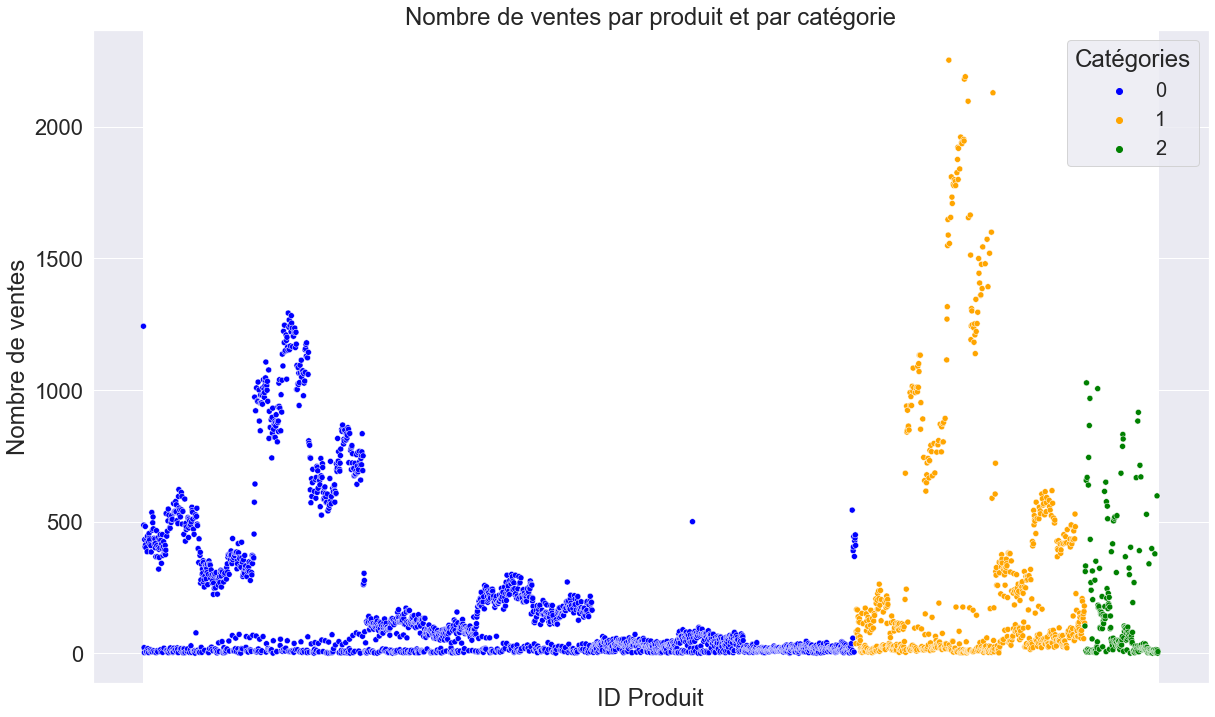

In [79]:
#L'axe des abscisses est l'ID produit, pour distinguer les catégories et améliorer la lisibilité
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g9 = sns.scatterplot(data=flops_count, x='id_prod', y='decompte', hue='categ', palette=['blue', 'orange', 'green'])
g9.tick_params(labelbottom=False)
plt.xlabel("ID Produit")
plt.ylabel("Nombre de ventes")
plt.title("Nombre de ventes par produit et par catégorie")
plt.legend(bbox_to_anchor=[1, 1], prop={'size': 20}, title='Catégories')
plt.show()

In [80]:
#Même principe sauf qu'on s'intéresse au chiffre d'affaire par produit et catégorie plutôt que nombre de ventes
flops_price = data.groupby(['id_prod', 'categ'])['price'].sum()
flops_price = flops_price.to_frame('chiffre_affaire').reset_index()
flops_p0 = flops_price.loc[flops_price['categ'] == 0].sort_values('chiffre_affaire').head(20)
flops_p0

,id_prod,categ,chiffre_affaire
595,0_1539,0,0.99
313,0_1284,0,1.38
719,0_1653,0,1.98
665,0_1601,0,1.99
1785,0_541,0,1.99
2080,0_807,0,1.99
802,0_1728,0,2.27
549,0_1498,0,2.48
2180,0_898,0,2.54
925,0_1840,0,2.56


In [81]:
flops_p1 = flops_price.loc[flops_price['categ'] == 1].sort_values('chiffre_affaire').head(20)
flops_p1

,id_prod,categ,chiffre_affaire
2649,1_420,1,14.24
2432,1_224,1,19.80
2704,1_470,1,21.64
2707,1_473,1,26.91
2631,1_404,1,29.55
2333,1_135,1,39.95
2624,1_399,1,43.89
2750,1_511,1,44.85
2668,1_438,1,47.16
2653,1_424,1,49.10


In [82]:
flops_p2 = flops_price.loc[flops_price['categ'] == 2].sort_values('chiffre_affaire').head(20)
flops_p2
#En terme de chiffre d'affaire, le plus gros flop en catégorie 2 vaut 87 fois le plus gros flop en catégorie 0

,id_prod,categ,chiffre_affaire
3248,2_81,2,86.99
3176,2_23,2,115.99
3264,2_98,2,149.74
3259,2_93,2,157.98
3040,2_107,2,203.94
3243,2_77,2,291.98
3189,2_27,2,295.96
3190,2_28,2,310.50
3057,2_122,2,350.00
3067,2_131,2,383.97


In [83]:
#On passe aux tops
tops_p0 = flops_price.loc[flops_price['categ'] == 0].sort_values('chiffre_affaire', ascending=False).head(20)
tops_p0

,id_prod,categ,chiffre_affaire
487,0_1441,0,23452.65
465,0_1421,0,23008.49
457,0_1414,0,22287.00
498,0_1451,0,21689.15
460,0_1417,0,21372.12
494,0_1448,0,20701.42
519,0_1470,0,20194.02
475,0_1430,0,20109.87
389,0_1353,0,19430.28
391,0_1355,0,19312.83


In [84]:
tops_p1 = flops_price.loc[flops_price['categ'] == 1].sort_values('chiffre_affaire', ascending=False).head(20)
tops_p1

,id_prod,categ,chiffre_affaire
2620,1_395,1,54356.25
2592,1_369,1,54025.48
2642,1_414,1,51949.40
2608,1_383,1,51486.24
2734,1_498,1,49731.36
2633,1_406,1,48106.59
2589,1_366,1,47005.38
2610,1_385,1,46730.02
2661,1_431,1,46575.36
2603,1_379,1,46098.92


In [85]:
tops_p2 = flops_price.loc[flops_price['categ'] == 2].sort_values('chiffre_affaire', ascending=False).head(20)
tops_p2
#A noter que le produit 2_159 n'est "que" 17ème en terme de nombre de ventes pour la catégorie 2

,id_prod,categ,chiffre_affaire
3097,2_159,2,94893.50
3071,2_135,2,69334.95
3046,2_112,2,65407.76
3035,2_102,2,60736.78
3153,2_209,2,56971.86
3044,2_110,2,53846.25
3202,2_39,2,53060.85
3105,2_166,2,52449.12
3207,2_43,2,49972.86
3146,2_202,2,46217.88


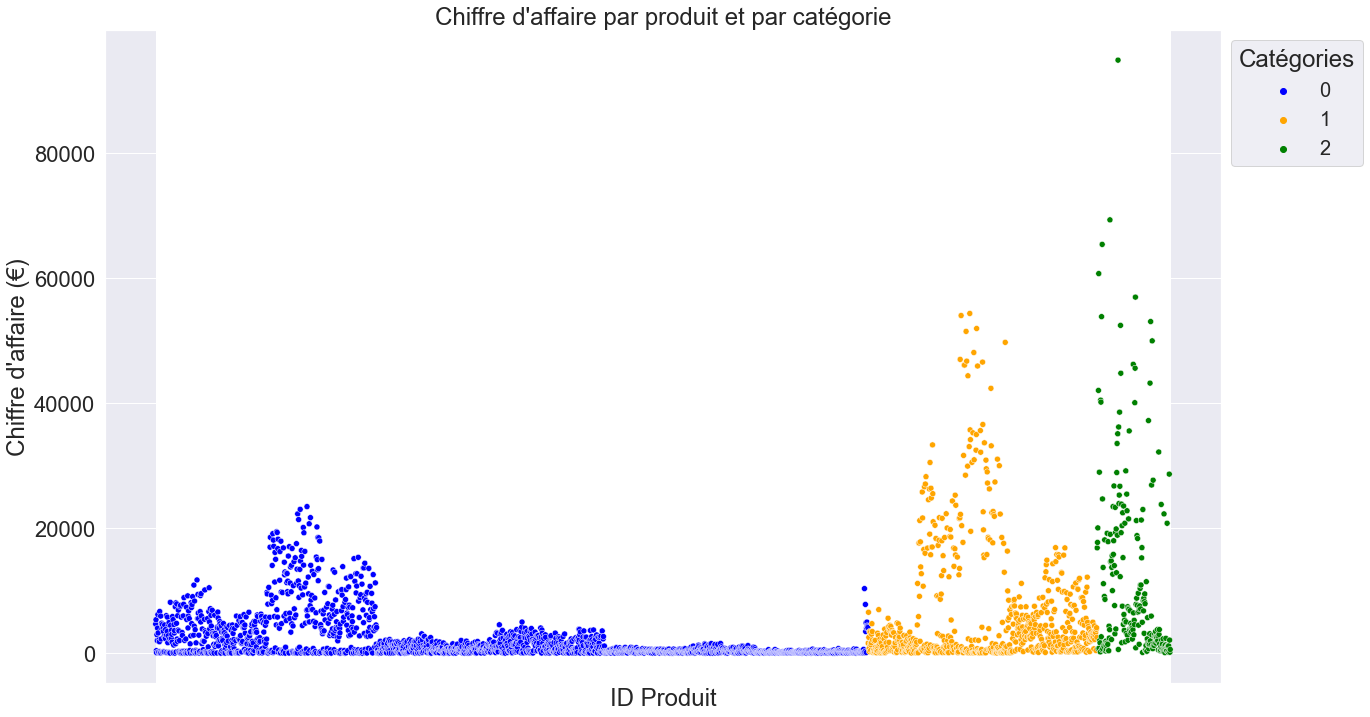

In [86]:
#Même remarque que tout à l'heure pour l'axe des abscisses
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g10 = sns.scatterplot(data=flops_price, x='id_prod', y='chiffre_affaire', hue='categ', palette=['blue', 'orange', 'green'])
g10.tick_params(labelbottom=False)
plt.xlabel("ID Produit")
plt.ylabel("Chiffre d'affaire (€)")
plt.title("Chiffre d'affaire par produit et par catégorie")
plt.legend(bbox_to_anchor=[1, 1], prop={'size': 20}, title='Catégories')
plt.show()

In [87]:
print('\033[1m' "Le nombre de vente plus faible des produits de catégorie 2 est contrebalancé par leur prix bien plus élevé. Les plus gros flops en terme de chiffre d'affaire sont des produits de catégorie 0." '\033[0m')

Le nombre de vente plus faible des produits de catégorie 2 est contrebalancé par leur prix bien plus élevé. Les plus gros flops en terme de chiffre d'affaire sont des produits de catégorie 0.


In [88]:
#ATTENTION CEPENDANT
idx = data.groupby('id_prod')['date'].idxmax()
data.loc[idx].sort_values('date').head(20)

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age
53794,0_1601,2021-03-07 18:55:24.042724,s_3132,c_1125,2021,2021-03,2021-03-07,1.99,0,f,1972,49
302353,2_98,2021-03-08 21:10:32.250919,s_3637,c_5967,2021,2021-03,2021-03-08,149.74,2,f,2003,18
553807,0_541,2021-03-08 23:45:11.524853,s_3676,c_1869,2021,2021-03,2021-03-08,1.99,0,f,1985,36
644717,0_886,2021-03-17 03:34:14.461358,s_7410,c_7219,2021,2021-03,2021-03-17,21.82,0,f,1966,55
512164,0_549,2021-04-11 04:42:10.308957,s_18930,c_4202,2021,2021-04,2021-04-11,2.99,0,f,1987,34
43322,0_1284,2021-04-14 13:13:06.560397,s_20477,c_1551,2021,2021-04,2021-04-14,1.38,0,m,1972,49
55050,0_1728,2021-04-19 13:48:18.949260,s_22772,c_2768,2021,2021-04,2021-04-19,2.27,0,f,1989,32
254215,0_1902,2021-05-08 15:08:20.669326,s_31690,c_4227,2021,2021-05,2021-05-08,2.28,0,m,1969,52
285779,0_1539,2021-06-01 08:53:24.523722,s_42501,c_881,2021,2021-06,2021-06-01,0.99,0,f,1988,33
577923,0_88,2021-06-11 15:31:20.504586,s_47243,c_1609,2021,2021-06,2021-06-11,8.30,0,m,1980,41


On a ici la date à laquelle certains produits ont été achetés pour la dernière fois. On constate que cela fait plus d'un an et demi pour presque tous les produits de ce top 20, et même pratiquement 2 ans pour une poignée de référence.

Je n'exclue pas l'hypothèse que certaines de ces références ont été retirées de la boutique entre temps et ne sont pas à proprement parler des flops.
# IV) Requêtes de Julie <a class="anchor" id="iv"></a>
## 1) Genre/catégorie <a class="anchor" id="iv1"></a>

In [89]:
#Je me méfie des 4 clients qu'on a identifié tout à l'heure, alors je creuse un peu plus avant l'analyse
clients = data.groupby('client_id')['session_id'].count().reset_index()
clients.rename(columns={'session_id':'decompte'}, inplace=True)
clients.sort_values('decompte', ascending=False).head(10)

,client_id,decompte
677,c_1609,25488
6337,c_6714,9187
2724,c_3454,6773
4388,c_4958,5195
2513,c_3263,403
1268,c_2140,402
1772,c_2595,398
1197,c_2077,384
708,c_1637,380
7120,c_7421,379


In [90]:
#Je supprime ces 4 clients, car j'ai peur qu'ils faussent les résultats
data_drop = data[~data['client_id'].isin(["c_1609", "c_4958", "c_6714", "c_3454"])].reset_index(drop=True)
data_drop

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0,f,1986,36
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1,m,1988,34
2,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2,m,2000,21
3,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0,m,1980,43
4,0_1418,2022-10-20 15:59:16.084030,s_285425,c_1478,2022,2022-10,2022-10-20,8.57,0,f,1972,50
...,...,...,...,...,...,...,...,...,...,...,...,...
632684,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0,f,1951,71
632685,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1,f,1977,45
632686,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0,f,1988,34
632687,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0,m,1986,35


In [91]:
#Pour la même raison, je supprime le mois d'octobre 2021
data_drop = data_drop.drop(data_drop.loc[data_drop['month'] == '2021-10'].index, inplace=False).reset_index(drop=True)
data_drop

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0,f,1986,36
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1,m,1988,34
2,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2,m,2000,21
3,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0,m,1980,43
4,0_1418,2022-10-20 15:59:16.084030,s_285425,c_1478,2022,2022-10,2022-10-20,8.57,0,f,1972,50
...,...,...,...,...,...,...,...,...,...,...,...,...
612621,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0,f,1951,71
612622,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1,f,1977,45
612623,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0,f,1988,34
612624,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0,m,1986,35


In [92]:
#Les variables catégories et genre étant qualitatives et non-appariées, nous utilisons le test du Chi-2
#Le test du Chi-2 teste l'hypothèse H0 selon laquelle les variables ne sont pas corrélées
X = 'sex'
Y = 'categ'

cont = data_drop[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)
cont

categ,0,1,2
sex,,,
f,192025,110550,16429
m,178044,100227,15351


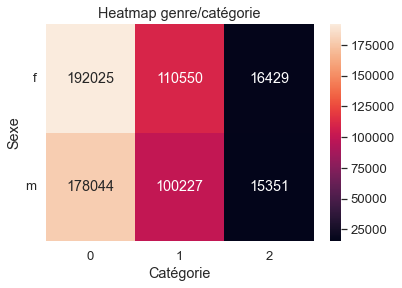

In [93]:
sns.set(font_scale=1.2)
sns.heatmap(cont, annot=True, fmt='g')
plt.xlabel("Catégorie")
plt.ylabel("Sexe")
plt.title("Heatmap genre/catégorie")
plt.yticks(rotation=0)
plt.show()

In [94]:
st.chi2_contingency(cont)

(18.75788251563821,
 8.448460261159054e-05,
 2,
 array([[192700.75262232, 109754.90120889,  16548.34616879],
        [177368.24737768, 101022.09879111,  15231.65383121]]))

In [95]:
print('\033[1m' "Avec une p-value de 0.00008 et un chi-2 supérieur à 5.99 pour α=0.05 et k=2 (en se fiant à la table du chi-2), nous devons réfuter H0. Il existe une corrélation entre genre et catégorie de produit." '\033[0m')

Avec une p-value de 0.00008 et un chi-2 supérieur à 5.99 pour α=0.05 et k=2 (en se fiant à la table du chi-2), nous devons réfuter H0. Il existe une corrélation entre genre et catégorie de produit.


Ce résultat est surprenant pour moi, car les valeurs auxquelles on pourrait s'attendre en cas d'indépendance des variables sont très similaires aux valeurs du tableau de contingence.

Je décide donc de creuser un peu plus loin et de calculer le V de Cramér, qui détermine l'intensité de la corrélation entre les variables.

In [96]:
X2 = st.chi2_contingency(cont)[0]
N = np.sum(cont).sum()
minimum_dimension = min(cont.shape)-1
CramersV = np.sqrt((X2/N) / minimum_dimension)
CramersV

0.005533427110161377

In [97]:
print('\033[1m' "On obtient un V de Cramér de 0.0055, qui suggère que la corrélation est extrêmement faible cependant. Ce qui est davantage en adéquation avec l'observation que j'ai fait plus haut." '\033[0m')

On obtient un V de Cramér de 0.0055, qui suggère que la corrélation est extrêmement faible cependant. Ce qui est davantage en adéquation avec l'observation que j'ai fait plus haut.


## 2) Requêtes liées à l'âge <a class="anchor" id="iv2"></a>
### i) Un peu de visualisation pour commencer <a class="anchor" id="iv2i"></a>

Afin de déterminer si je préfère travailler par âge ou par groupe d'âge, je vais créer quelques graphiques.

In [98]:
#On commence par âge et montant des achats
age_montant = data_drop.groupby(['client_id','age'])['price'].sum().reset_index()
age_montant.rename(columns={'price':'montant'}, inplace=True)
age_montant

,client_id,age,montant
0,c_1,66,286.67
1,c_1,67,219.23
2,c_1,68,44.29
3,c_10,65,586.18
4,c_10,66,602.93
...,...,...,...
24159,c_998,21,1179.06
24160,c_998,22,498.96
24161,c_999,57,206.63
24162,c_999,58,394.11


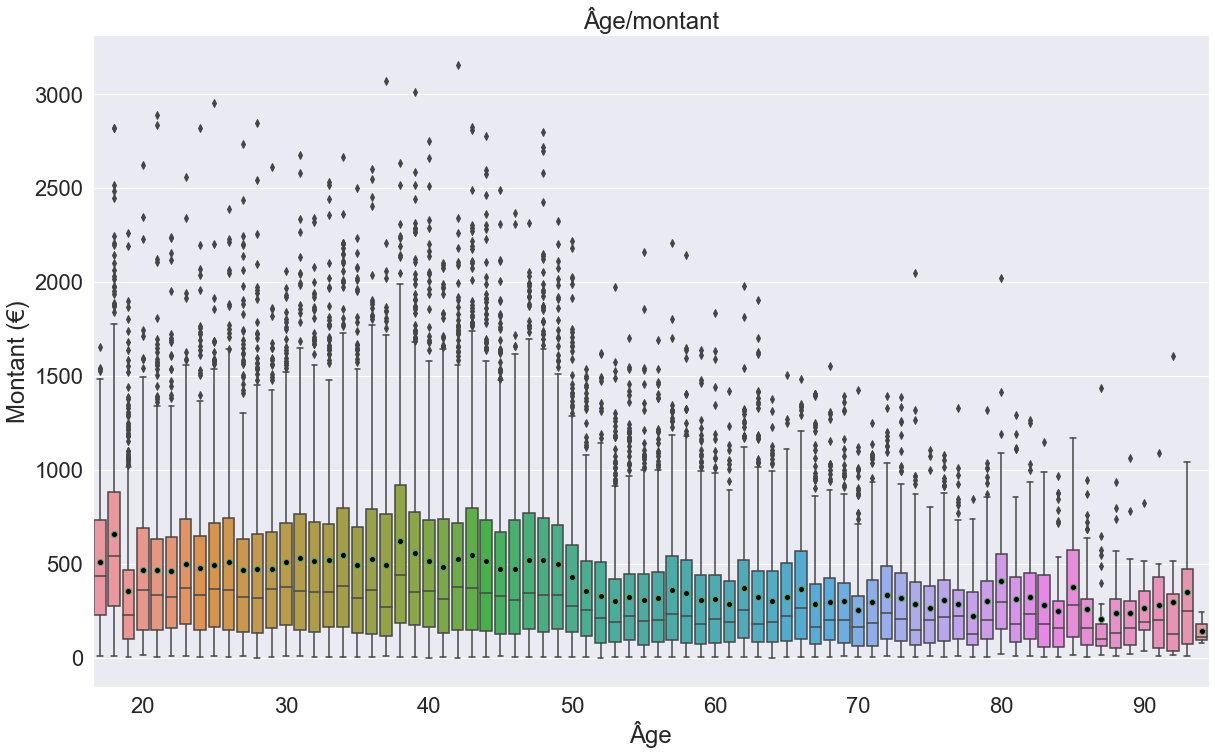

In [99]:
#Je trouve le boxplot plus facile à lire que le scatterplot ou regplot dans ce cas de figure
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g11 = sns.boxplot(data=age_montant, x='age', y='montant', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Montant (€)")
plt.title("Âge/montant")
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])

plt.show()
#Difficile d'identifier des groupes d'âge ici

In [100]:
#On passe à l'âge et la fréquence d'achats, je m'appuie sur une fréquence mensuelle
age_frequence = data_drop.groupby(['client_id', 'age', 'year'])['session_id'].count().reset_index()
age_frequence.rename(columns={'session_id':'nb_session'}, inplace=True)
#Un peu barbare, mais comme j'ai plus d'un âge par client il est nécessaire de diviser par le bon nombre de mois
#On divise le nombre de sessions par 10 pour les commandes passées en 2021, par 12 pour 2022 et par 2 pour 2023
age_frequence['frequence'] = np.where(age_frequence['year'] == '2021', round(age_frequence['nb_session'] / 10, 2),
                                      np.where(age_frequence['year'] == '2022', round(age_frequence['nb_session'] / 12, 2),
                                               round(age_frequence['nb_session'] / 2)))
age_frequence

,client_id,age,year,nb_session,frequence
0,c_1,66,2021,18,1.80
1,c_1,67,2022,18,1.50
2,c_1,68,2023,2,1.00
3,c_10,65,2021,28,2.80
4,c_10,66,2022,25,2.08
...,...,...,...,...,...
24159,c_998,21,2022,25,2.08
24160,c_998,22,2023,4,2.00
24161,c_999,57,2021,15,1.50
24162,c_999,58,2022,23,1.92


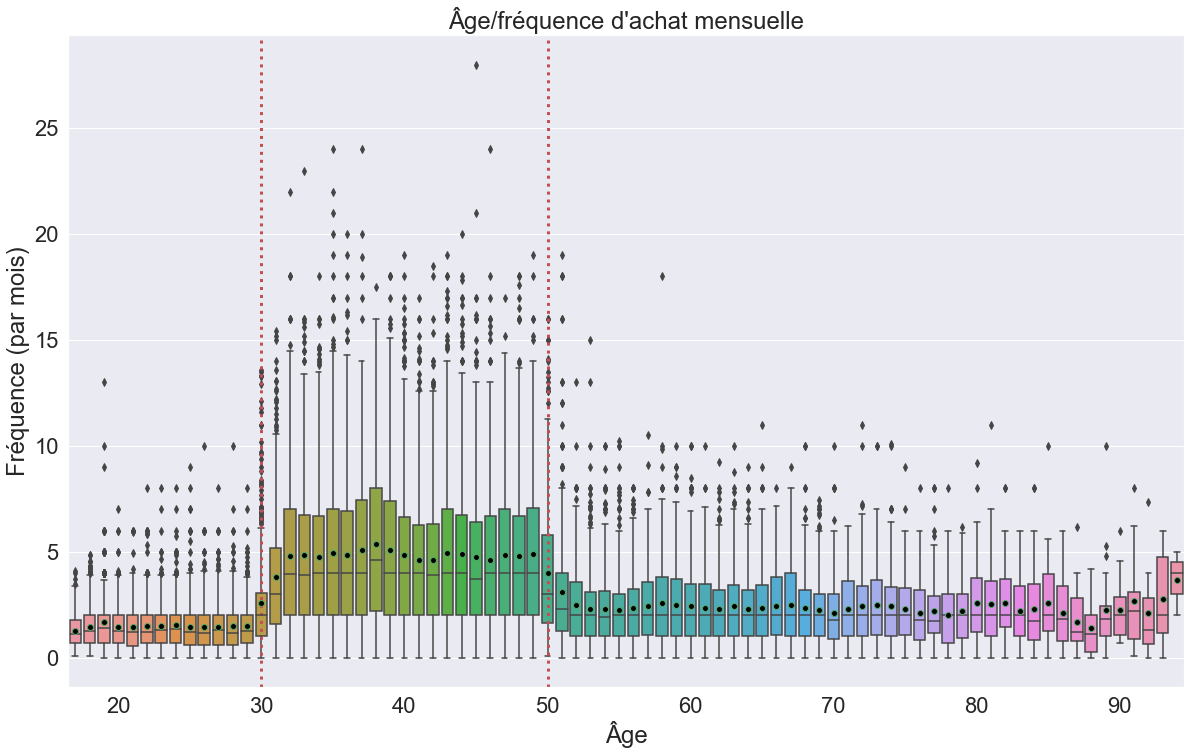

In [101]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g12 = sns.boxplot(data=age_frequence, x='age', y='frequence', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Fréquence (par mois)")
plt.title("Âge/fréquence d'achat mensuelle")
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.axvline(x=33, color='r', linestyle=':', linewidth=3)
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.show()
#Il semble apparaître 3 tranches d'âge ici

In [102]:
#On passe à l'âge et la taille du panier, on cherche la taille de chaque panier d'abord
age_taille = data_drop.groupby(['client_id', 'age','session_id'])['id_prod'].count().reset_index()
age_taille.rename(columns={'id_prod':'taille'}, inplace=True)
age_taille

,client_id,age,session_id,taille
0,c_1,66,s_114737,5
1,c_1,66,s_120172,2
2,c_1,66,s_134971,1
3,c_1,66,s_136532,1
4,c_1,66,s_139610,1
...,...,...,...,...
308510,c_999,59,s_326624,1
308511,c_999,59,s_327362,1
308512,c_999,59,s_330231,2
308513,c_999,59,s_333631,1


In [103]:
#Puis on calcule la moyenne par âge et par client
panier_moyen = age_taille.groupby(['client_id', 'age'])['taille'].mean().reset_index()
panier_moyen

,client_id,age,taille
0,c_1,66,1.384615
1,c_1,67,1.000000
2,c_1,68,2.000000
3,c_10,65,1.750000
4,c_10,66,1.666667
...,...,...,...
24159,c_998,21,2.272727
24160,c_998,22,2.000000
24161,c_999,57,1.071429
24162,c_999,58,1.095238


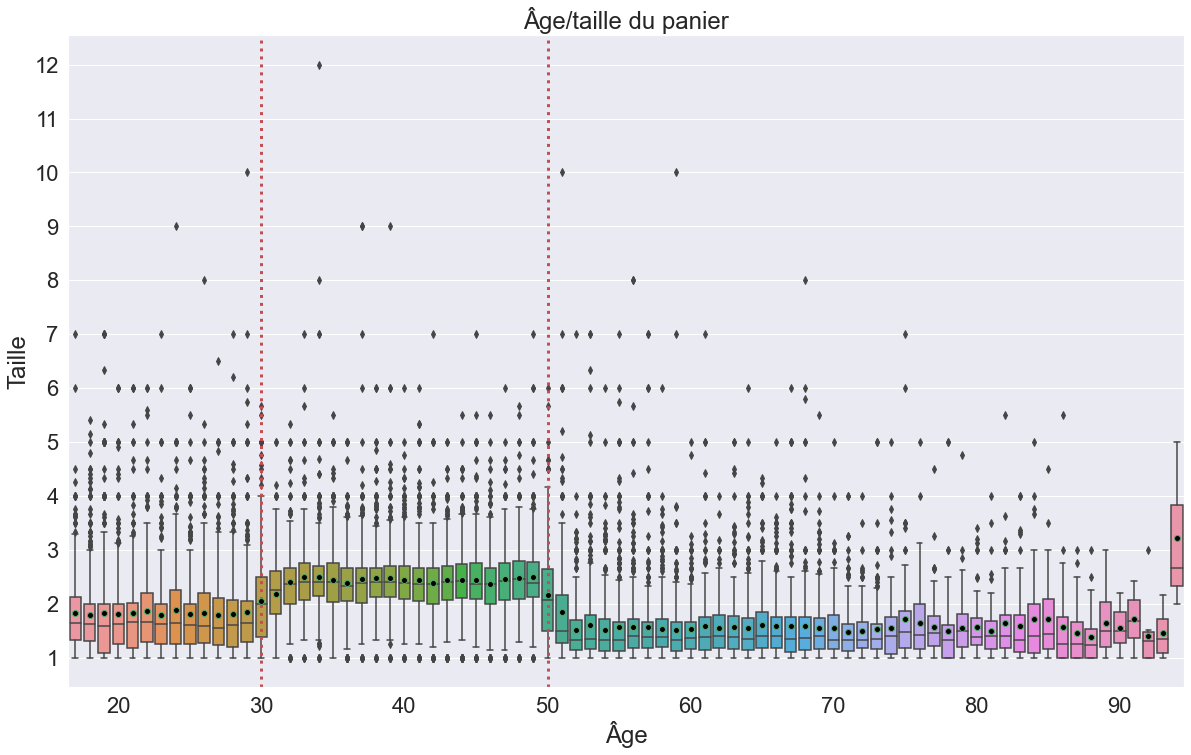

In [104]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g13 = sns.boxplot(data=panier_moyen, x='age', y='taille', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Taille")
plt.title("Âge/taille du panier")
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.axvline(x=33, color='r', linestyle=':', linewidth=3)
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.yticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.show()
#Les 3 mêmes tranches d'âge sembkent apparaître ici

In [105]:
#Enfin, on passe à l'âge et la catégorie de produit
age_categ = data_drop.groupby(['categ', 'client_id', 'age'])['id_prod'].count().reset_index()
age_categ.rename(columns={'id_prod':'decompte'}, inplace=True)
age_categ

,categ,client_id,age,decompte
0,0,c_1,66,13
1,0,c_1,67,16
2,0,c_10,65,10
3,0,c_10,66,8
4,0,c_10,67,2
...,...,...,...,...
50313,2,c_997,27,5
50314,2,c_997,28,9
50315,2,c_998,20,11
50316,2,c_998,21,13


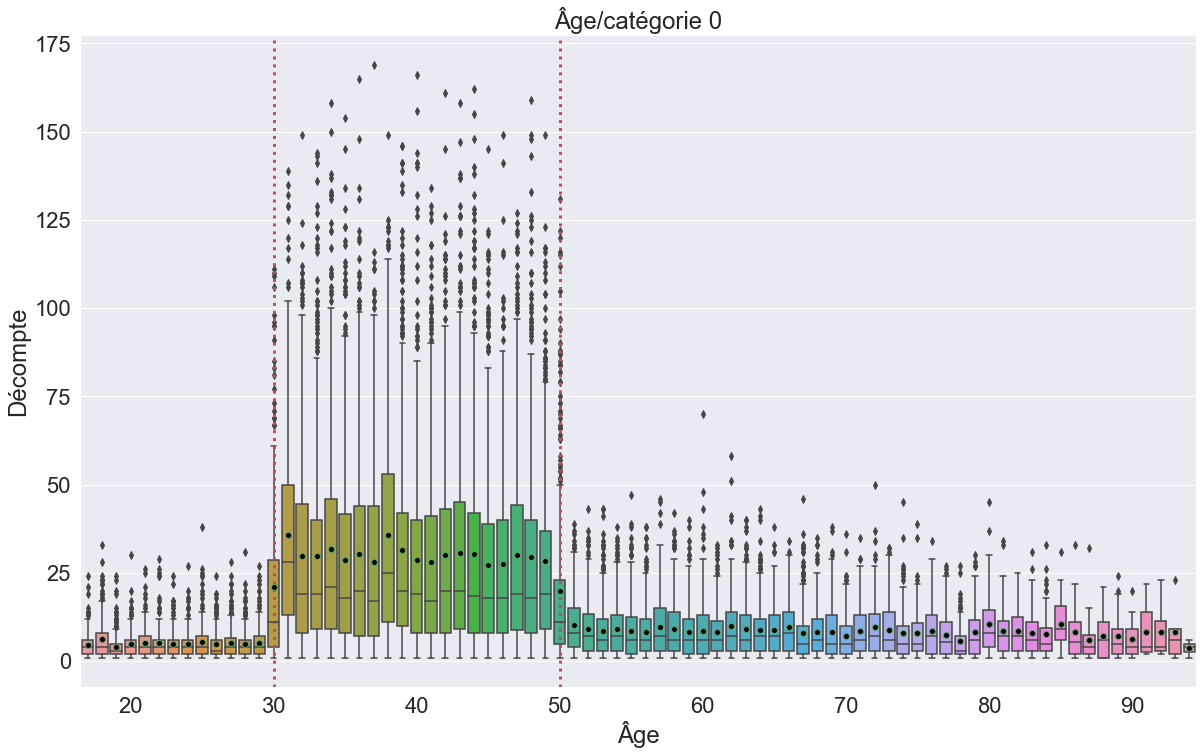

In [106]:
#Je dessine 3 plots parce que sur un seul c'était trop lourd
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g14 = sns.boxplot(data=age_categ.loc[age_categ['categ'] == 0], x='age', y='decompte', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Décompte")
plt.title("Âge/catégorie 0")
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.axvline(x=33, color='r', linestyle=':', linewidth=3)
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.show()

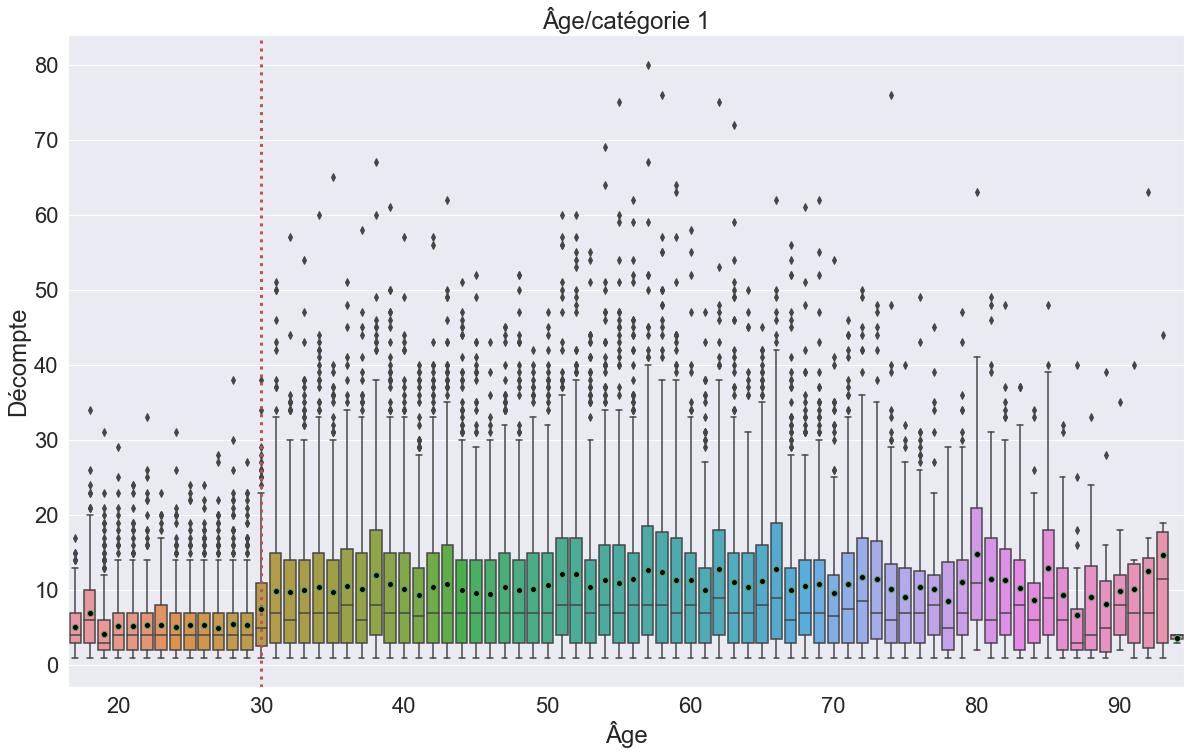

In [107]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g15 = sns.boxplot(data=age_categ.loc[age_categ['categ'] == 1], x='age', y='decompte', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Décompte")
plt.title("Âge/catégorie 1")
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.show()

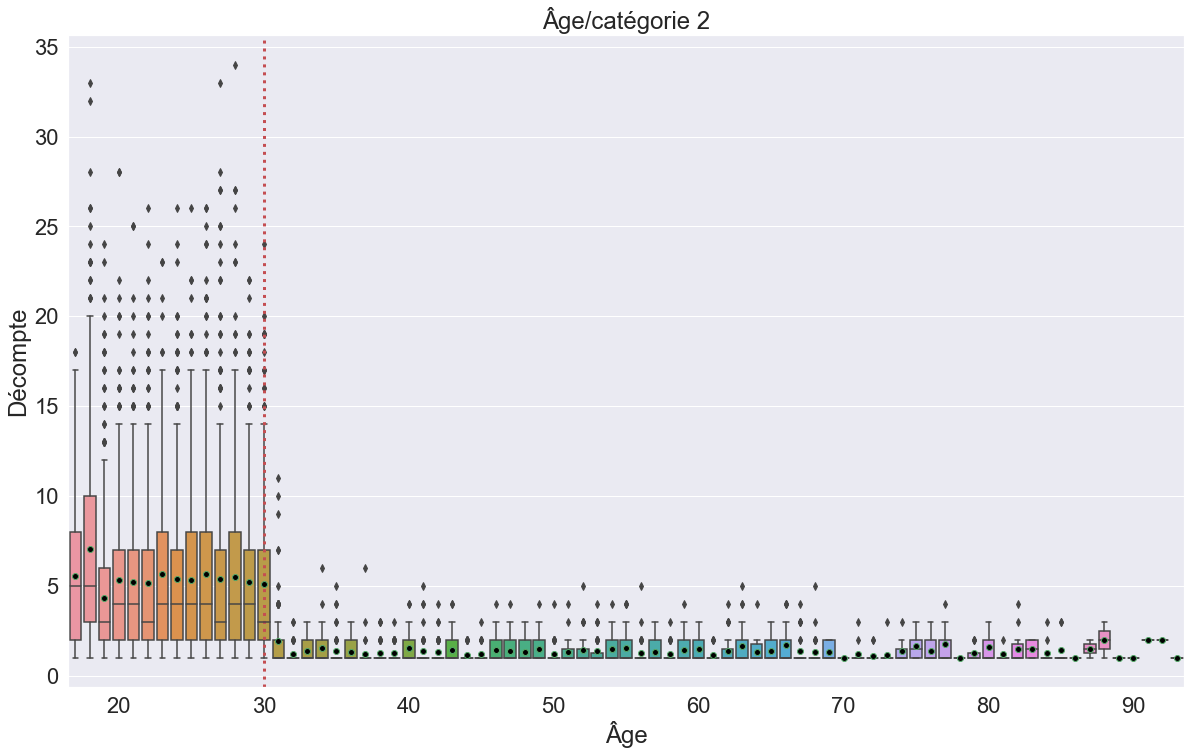

In [108]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g16 = sns.boxplot(data=age_categ.loc[age_categ['categ'] == 2], x='age', y='decompte', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Décompte")
plt.title("Âge/catégorie 2")
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.show()

Sur la majorité des graphiques il semble se distinguer 3 groupes : Les moins de 30 ans, les 30-50 ans et les plus de 50 ans. Ce qui coïncide avec l'observation qu'on a fait plus tôt, concernant la moyenne du chiffre d'affaire en fonction de l'âge des clients.

La seule exception étant le graphique âge/montant pour lequel nous n'avons pas clairement identifié de groupe d'âge.

Nous créerons donc des groupes d'âge avant de passer aux tests, en temps voulu.

### ii) Âge/montant <a class="anchor" id="iv2ii"></a>

In [109]:
#Le test de Kolmogorov-Smirnov teste l'hypothèse H0 selon laquelle les variables suivent la même loi de distribution
st.ks_2samp(age_montant['age'], age_montant['montant'])

KstestResult(statistic=0.8165038900844231, pvalue=0.0)

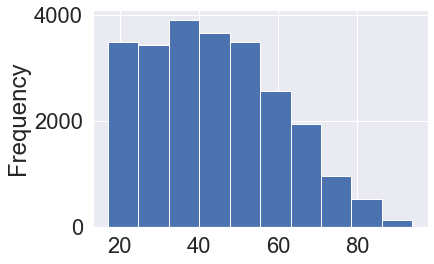

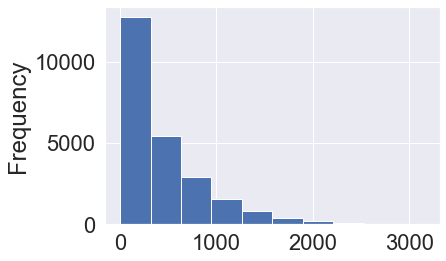

In [110]:
#Avec un p-value nulle, le test suggère 2 lois de distributions différentes
#Ce qui est conforme à l'observation qu'on peut faire des 2 histogrammes ci-dessous
age_montant['age'].plot(kind='hist')
plt.show()
age_montant['montant'].plot(kind='hist')
plt.show()

Les variables âge et montant étant quantitatives, non-appariées et de distributions différentes, nous utilisons un test non-paramétrique, à savoir la corrélation de Spearman pour déterminer si elles sont corrélées ou non.

In [111]:
#La corrélation de Spearman teste l'hypothèse H0 selon laquelle les variables ne sont pas corrélées
st.spearmanr(age_montant['age'], age_montant['montant'])

SpearmanrResult(correlation=-0.1803768959070022, pvalue=8.105686843470679e-176)

La p-value étant pratiquement égale à 0, nous devons rejeter H0 et déduire qu'il y a corrélation entre âge et montant d'achat. Le coefficient étant négatif, on en déduit que la corrélation est négative. Càd qu'à mesure que l'âge des clients augmente, le montant des achats diminue.

Ce qui est conforme au graphique qu'on a vu précédemment, où les personnes de plus de 50/60 ans semblaient dépenser moins.

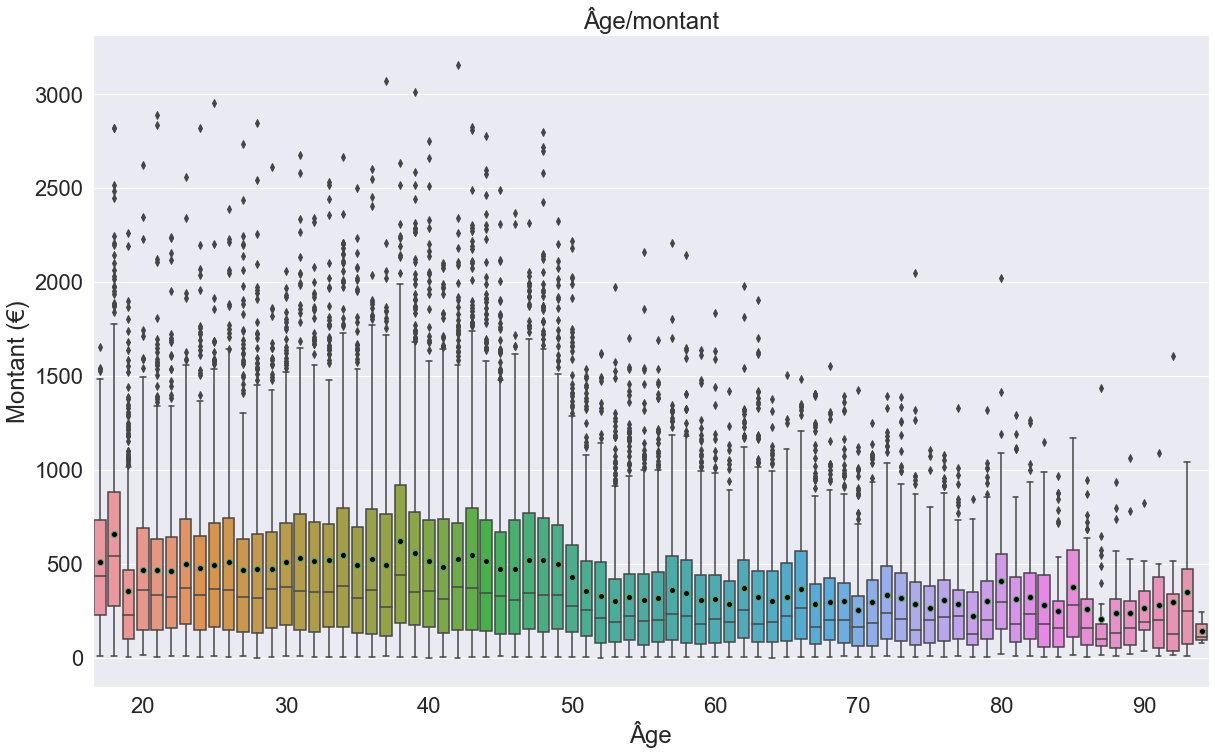

In [112]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g11 = sns.boxplot(data=age_montant, x='age', y='montant', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Montant (€)")
plt.title("Âge/montant")
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])

plt.show()

### iii) Âge/fréquence <a class="anchor" id="iv2iii"></a>

In [113]:
#On créé une colonne groupe d'âge
bins= [0,30,51,100]
labels = ['-30','30-50','50+']
g_age_frequence = age_frequence.copy()
g_age_frequence['groupe_age'] = pd.cut(g_age_frequence['age'], bins=bins, labels=labels, right=False)
g_age_frequence

,client_id,age,year,nb_session,frequence,groupe_age
0,c_1,66,2021,18,1.80,50+
1,c_1,67,2022,18,1.50,50+
2,c_1,68,2023,2,1.00,50+
3,c_10,65,2021,28,2.80,50+
4,c_10,66,2022,25,2.08,50+
...,...,...,...,...,...,...
24159,c_998,21,2022,25,2.08,-30
24160,c_998,22,2023,4,2.00,-30
24161,c_999,57,2021,15,1.50,50+
24162,c_999,58,2022,23,1.92,50+


In [114]:
#Dans ce cas de figure et le suivant, nous comparons une variable qualitative ordinale et une variable quantitative
#On commence par tester l’adéquation de la fréquence à une loi normale à l’aide de Kolmogorov-Smirnov
#Le test de Shapiro-Wilk est une autre option, mais il n'est pas recommandé quand n>5000
st.ks_2samp(g_age_frequence['frequence'],
            list(np.random.normal(np.mean(g_age_frequence['frequence']), np.std(g_age_frequence['frequence']), 1000)))

KstestResult(statistic=0.14883512663466314, pvalue=4.996859474904139e-19)

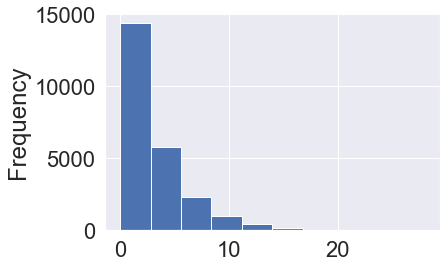

In [115]:
#Avec un p-value quasi nulle, le test suggère qu'il n'y a pas de normalité
#Ce qui est conforme à l'observation qu'on peut faire sur cet histogramme
g_age_frequence['frequence'].plot(kind='hist')
plt.show()

In [116]:
#La corrélation de Spearman est encore adaptée ici
st.spearmanr(g_age_frequence['frequence'], g_age_frequence['groupe_age'])

SpearmanrResult(correlation=0.10092155236971913, pvalue=9.818774799169196e-56)

La p-value étant encore une fois pratiquement égale à 0, nous devons rejeter H0 et déduire qu'il y a corrélation entre âge et fréquence d'achat. Le coefficient étant positif, on en déduit que la corrélation est positive. Càd qu'à mesure que l'âge des clients augmente, la fréquence d'achat augmente. Le coefficient est également ~0.1, ce qui suggère que la corrélation n'est pas très forte.

Ce qui n'est pas tout à fait conforme au graphique qu'on a vu précédemment, où les personnes de 30/50 ans semblaient passer commande plus fréquemment que les personnes de plus de 50 ans, qui elles-mêmes semblaient passer commande plus fréquemment que les moins de 30 ans. C'est là la limite de la corrélation de Spearman, qui n'est adaptée que pour calculer des corrélations linéaires.

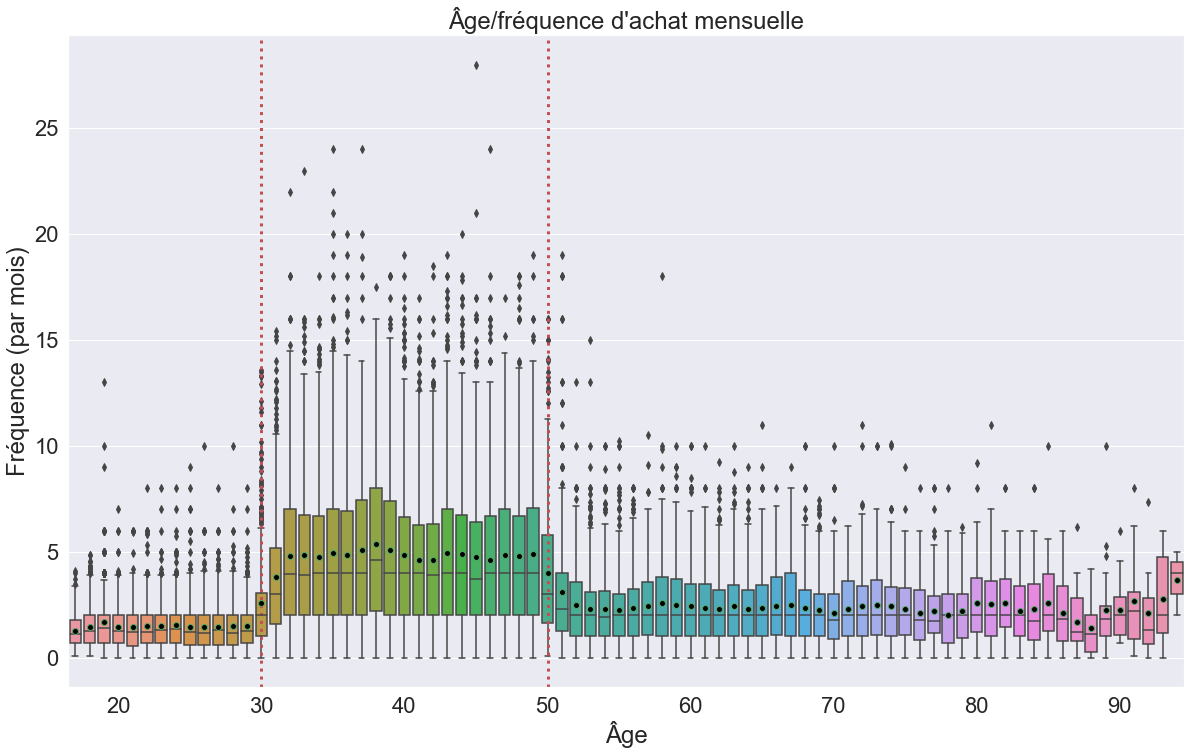

In [117]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g12 = sns.boxplot(data=age_frequence, x='age', y='frequence', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Fréquence (par mois)")
plt.title("Âge/fréquence d'achat mensuelle")
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.axvline(x=33, color='r', linestyle=':', linewidth=3)
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.show()

### iv) Âge/taille du panier <a class="anchor" id="iv2iv"></a>

In [118]:
#On créé une colonne groupe d'âge
bins= [0,30,51,100]
labels = ['-30','30-50','50+']
g_age_taille = panier_moyen.copy()
g_age_taille['groupe_age'] = pd.cut(g_age_taille['age'], bins=bins, labels=labels, right=False)
g_age_taille

,client_id,age,taille,groupe_age
0,c_1,66,1.384615,50+
1,c_1,67,1.000000,50+
2,c_1,68,2.000000,50+
3,c_10,65,1.750000,50+
4,c_10,66,1.666667,50+
...,...,...,...,...
24159,c_998,21,2.272727,-30
24160,c_998,22,2.000000,-30
24161,c_999,57,1.071429,50+
24162,c_999,58,1.095238,50+


In [119]:
#Comme pour âge/fréquence, on commence par un test de Kolmogorov-Smirnov
st.ks_2samp(g_age_taille['taille'],
            list(np.random.normal(np.mean(g_age_taille['taille']), np.std(g_age_taille['taille']), 1000)))

KstestResult(statistic=0.112, pvalue=6.050696540616492e-11)

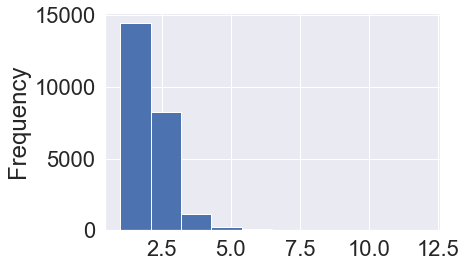

In [120]:
#Et comme pour âge/fréquence, le test suggère qu'il n'y a pas de normalité
#Ce qui est conforme à l'observation qu'on peut faire sur cet histogramme
g_age_taille['taille'].plot(kind='hist')
plt.show()

In [121]:
#La corrélation de Spearman est encore adaptée ici
st.spearmanr(g_age_taille['taille'], g_age_taille['groupe_age'])

SpearmanrResult(correlation=-0.2159964996500395, pvalue=4.99746835771978e-253)

La p-value étant encore une fois pratiquement égale à 0, nous devons rejeter H0 et déduire qu'il y a corrélation entre âge et taille des paniers. Le coefficient étant négatif, on en déduit que la corrélation est négative. Càd qu'à mesure que l'âge des clients augmente, la taille des paniers diminue.

Comme pour âge/fréquence, ce n'est pas tout à fait conforme au graphique qu'on a vu précédemment, où les personnes de 30/50 ans semblaient commander de plus gros paniers que les personnes de moins de 30 ans, qui elles-mêmes semblaient commander de plus gros paniers que les plus de 50 ans.

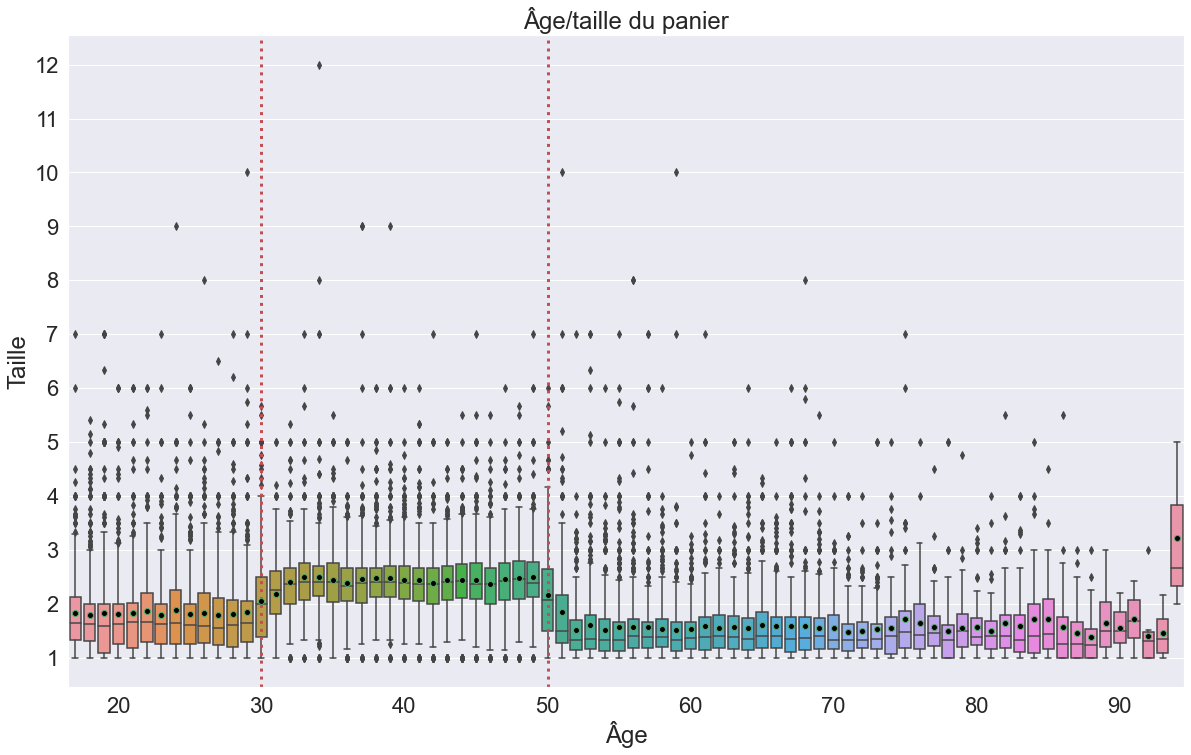

In [122]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
g13 = sns.boxplot(data=panier_moyen, x='age', y='taille', showmeans=True,
                  meanprops={'marker':'o', 'markerfacecolor':'black'})
plt.xlabel("Âge")
plt.ylabel("Taille")
plt.title("Âge/taille du panier")
plt.axvline(x=13, color='r', linestyle=':', linewidth=3)
plt.axvline(x=33, color='r', linestyle=':', linewidth=3)
plt.xticks([3,13,23,33,43,53,63,73], [20,30,40,50,60,70,80,90])
plt.yticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.show()

### v) Âge/catégorie <a class="anchor" id="iv2v"></a>

In [123]:
#On créé une colonne groupe d'âge
bins= [0,30,51,100]
labels = ['-30','30-50','50+']
g_age_data = data_drop.copy()
g_age_data['groupe_age'] = pd.cut(g_age_data['age'], bins=bins, labels=labels, right=False)
g_age_data

,id_prod,date,session_id,client_id,year,month,day,price,categ,sex,birth,age,groupe_age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022,2022-05,2022-05-20,4.18,0,f,1986,36,30-50
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2022,2022-02,2022-02-02,15.99,1,m,1988,34,30-50
2,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2021,2021-06,2021-06-24,69.99,2,m,2000,21,-30
3,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,2023,2023-01,2023-01-11,4.99,0,m,1980,43,30-50
4,0_1418,2022-10-20 15:59:16.084030,s_285425,c_1478,2022,2022-10,2022-10-20,8.57,0,f,1972,50,30-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612621,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,2022,2022-01,2022-01-15,12.99,0,f,1951,71,50+
612622,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,2022,2022-03,2022-03-19,10.99,1,f,1977,45,30-50
612623,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,2022,2022-12,2022-12-20,12.99,0,f,1988,34,30-50
612624,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,2021,2021-07,2021-07-16,4.98,0,m,1986,35,30-50


In [124]:
#Les variables catégories et groupe d'âge étant qualitatives et non-appariées, nous utilisons le test du Chi-2
X = 'groupe_age'
Y = 'categ'

cont2 = g_age_data[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)
cont2

categ,0,1,2
groupe_age,,,
-30,15161,26402,27394
30-50,287281,95210,2972
50+,67627,89165,1414


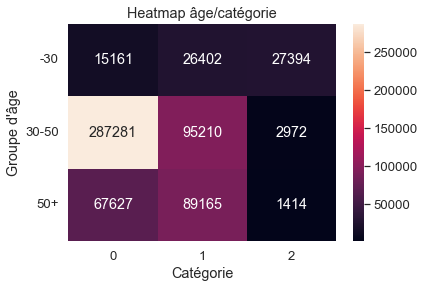

In [125]:
sns.set(font_scale=1.2)
sns.heatmap(cont2, annot=True, fmt='g')
plt.xlabel("Catégorie")
plt.ylabel("Groupe d'âge")
plt.title("Heatmap âge/catégorie")
plt.yticks(rotation=0)
plt.show()

In [126]:
st.chi2_contingency(cont2)

(249454.36289940987,
 0.0,
 4,
 array([[ 41654.85636098,  23724.99630933,   3577.14732969],
        [232846.64207363, 132620.44828492,  19995.90964145],
        [ 95567.50156539,  54431.55540575,   8206.94302886]]))

In [127]:
print('\033[1m' "Avec une p-value de 0.0 et un chi-2 très largement supérieur à 9.49 pour α=0.05 et k=4 (en se fiant à la table du chi-2), nous devons réfuter H0. Il existe une corrélation entre âge et catégorie de produit." '\033[0m')

Avec une p-value de 0.0 et un chi-2 très largement supérieur à 9.49 pour α=0.05 et k=4 (en se fiant à la table du chi-2), nous devons réfuter H0. Il existe une corrélation entre âge et catégorie de produit.


In [128]:
#Je calcule à nouveau le V de Cramér pour déterminer l'intensité de la corrélation
X2_2 = st.chi2_contingency(cont2)[0]
N_2 = np.sum(cont2).sum()
minimum_dimension_2 = min(cont2.shape)-1
CramersV2 = np.sqrt((X2_2/N_2) / minimum_dimension_2)
CramersV2

0.45121428650820494

In [129]:
print('\033[1m' "On obtient un V de Cramér proche de 0.5, qui suggère qu'il y a une très forte corrélation. Ce qui est en adéquation avec la heatmap où les 30-50 ans sont plus friands de catégorie 0, les plus de 50 ans de catégorie 1 et les moins de 30 ans de catégorie 2." '\033[0m')

On obtient un V de Cramér proche de 0.5, qui suggère qu'il y a une très forte corrélation. Ce qui est en adéquation avec la heatmap où les 30-50 ans sont plus friands de catégorie 0, les plus de 50 ans de catégorie 1 et les moins de 30 ans de catégorie 2.


### vi) Quelle coïncidence ! <a class="anchor" id="iv2vi"></a>
Cette information, couplée au fait que les moins de 30 ans sont responsables d'~86% des ventes de produits de catégorie 2 (produits qui sont en moyenne bien plus coûteux que les produits de catégories 0 et 1), explique un autre graphique qu'on a vu plus tôt. Celui de la moyenne de chiffre d'affaire en fonction de l'âge des clients.

<function matplotlib.pyplot.show(close=None, block=None)>

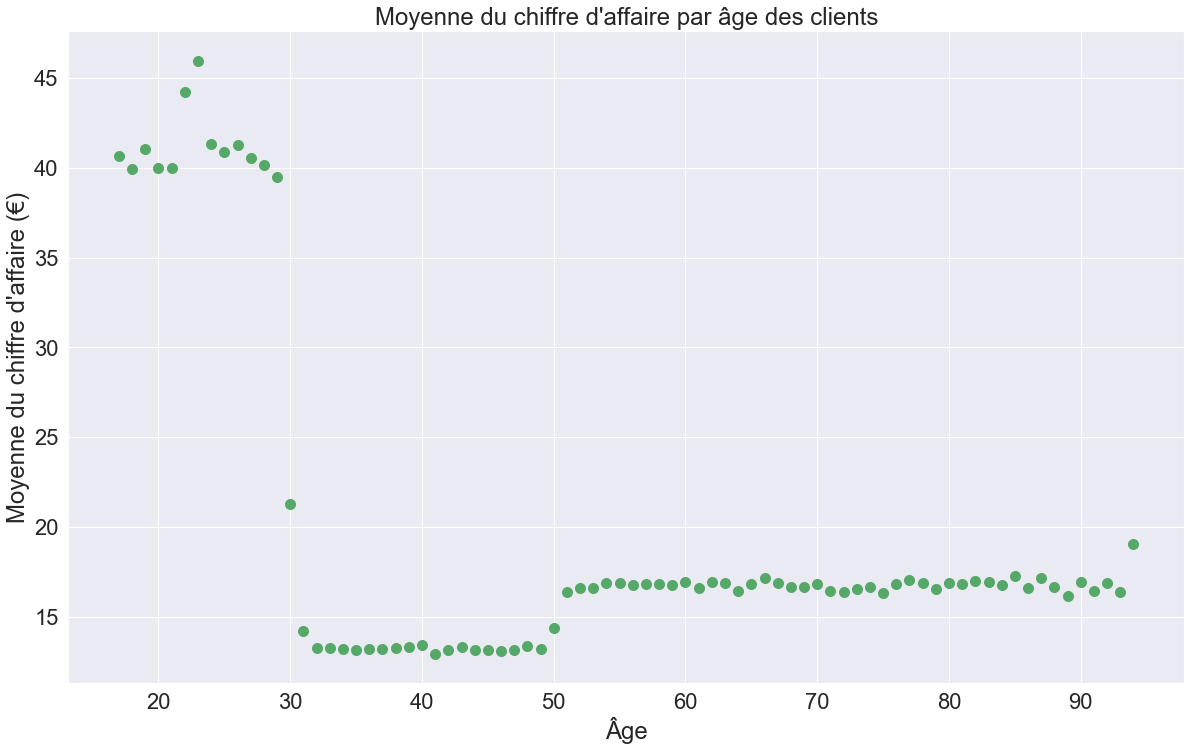

In [130]:
sns.set(font_scale=2)
g8 = ca_age_moy.plot(kind="scatter", x='age', y='moyenne_ca', color='g', figsize=(20,12), s=100)
plt.title("Moyenne du chiffre d'affaire par âge des clients")
plt.ylabel("Moyenne du chiffre d'affaire (€)")
plt.xlabel("Âge")
sns.set_theme(style='whitegrid', palette='dark')
plt.show()

# Conclusion <a class="anchor" id="conclusion"></a>

La baisse de chiffre d'affaire soudaine au mois d'octobre 2021 est due à une absence totale de vente de produits de catégorie 1 pendant plus de 3 semaines. Je ne peux que supposer qu'il s'agisse d'une erreur système plutôt qu'un manque de commandes.

Les produits de catégorie 2 génèrent moins de vente auprès des clients de plus de 30 ans, mais ils représentent une part non-négligeable du chiffre d'affaire de part leur prix de vente plus élevé.

4 de nos clients ont des dépenses exhorbitantes. Des revendeurs peut-être ?

Les clients de 30-50 ans sont nos clients les plus nombreux, passent de plus grosses commandes, et plus fréquemment que le reste de la clientèle, mais majoritairement des produits bon marché.